Starting from a 
* pre-trained model with a 
* pre-trained tokenizer

we perform finetuning on a negation task

In [26]:
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
import random
from tqdm import tqdm

from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch import device, cuda

import apex

import dcc_splitter as splitter
import ner_training as trainer
import pandas as pd

import seaborn
import matplotlib.pyplot as plt

from collections import namedtuple

from transformers import AutoTokenizer, RobertaTokenizer, AutoModelForTokenClassification

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [28]:
device = device("cuda:0") if cuda.is_available() else device("cpu")

In [29]:
device

device(type='cpu')

In [4]:
dcc_dir = None
output_dir = None
skip_file = None
n_splits = 10
random_state = None
base_folder = "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels"
output_folder = "fine_tuned_token_classification"
mod_name = "bert-base-dutch" # "robbert-v2-dutch-base" # belabBERT_115k # bert-base-dutch
 

args = namedtuple
args.task = "negation" # experiencer, temporality
args.model_path = os.path.join(base_folder, mod_name)
args.model_type = "roberta" # bertje
args.output_dir = os.path.join(base_folder, output_folder)
args.num_epochs = 4
args.eval_steps = 10 
args.lr = 5e-5
args.batch_size=16
args.gradient_accumulation_steps=1
args.block_size = 32
args.save_model=False
args.bio=True
args.do_eval=True
args.do_write=False
args.bootstrap=False
args.do_print_class_report=False

random.seed(77)

In [5]:
# dcc-splitter for folds
dcc_splitter = splitter.DCCSplitter(dcc_dir, output_dir, skip_file, n_splits, random_state, write_to_file=False)
splits = dcc_splitter.split()

In [6]:
# load NER DCC set
dcc = pd.read_csv("../data/RobBERT/DCC.tsv", 
                  sep="\t", 
                  skip_blank_lines=True, 
                  engine="python", 
                  encoding="utf-8",
                  on_bad_lines="warn", 
                  keep_default_na=False)

Skipping line 13610: field larger than field limit (131072)
Skipping line 20017: field larger than field limit (131072)
Skipping line 33436: field larger than field limit (131072)
Skipping line 39932: field larger than field limit (131072)
Skipping line 48840: field larger than field limit (131072)
Skipping line 67717: field larger than field limit (131072)
Skipping line 70612: field larger than field limit (131072)
Skipping line 75877: field larger than field limit (131072)
Skipping line 98174: field larger than field limit (131072)


In [7]:
dcc.loc[dcc.Id=='GP2218'][['Word', 'BIO', 'Negation', 'Experiencer', 'Temporality']].values

array([['Trombofilie', 'B', 'NotNegated', 'Patient', 'Recent'],
       ['O', 'O', 'O', 'O', 'O'],
       ['?', 'O', 'O', 'O', 'O'],
       ['ACUUT', 'O', 'O', 'O', 'O'],
       ['ANTERO', 'O', 'O', 'O', 'O'],
       ['Car', 'O', 'O', 'O', 'O'],
       ['[O]', 'O', 'O', 'O', 'O'],
       ['SEPTAAL', 'O', 'O', 'O', 'O'],
       ['-', 'O', 'O', 'O', 'O'],
       ['ANTEROLATERAAL', 'O', 'O', 'O', 'O'],
       ['INFARCT', 'B', 'NotNegated', 'Patient', 'Recent'],
       ['.', 'O', 'O', 'O', 'O'],
       ['ER', 'O', 'O', 'O', 'O'],
       ['WERD', 'O', 'O', 'O', 'O'],
       ['EEN', 'O', 'O', 'O', 'O'],
       ['STENT', 'O', 'O', 'O', 'O'],
       ['GE', 'O', 'O', 'O', 'O'],
       ['Car', 'O', 'O', 'O', 'O'],
       ['[O]', 'O', 'O', 'O', 'O'],
       ['IMPLANTEERD', 'O', 'O', 'O', 'O'],
       ['IN', 'O', 'O', 'O', 'O'],
       ['DE', 'O', 'O', 'O', 'O'],
       ['LAD', 'O', 'O', 'O', 'O'],
       ['.', 'O', 'O', 'O', 'O'],
       ['NA', 'O', 'O', 'O', 'O'],
       ['PTCA', 'O', 'O', 'O', '

In [8]:
tag_ids = {'negation':{'B-Negated':0,'B-NotNegated':1,'I-Negated':2,'I-NotNegated':3},
          'temporality':{'B-Recent':0,'B-Historical':1,'B-Hypothetical':2,'I-Recent':3,'I-Historical':4,'I-Hypothetical':5},
          'experiencer':{'B-Patient':0,'B-Other':1,'I-Patient':2,'I-Other':3}}

tag2id = tag_ids[args.task]
tokenizer = AutoTokenizer.from_pretrained(args.model_path)

## Over all document sources

improvement: only output best model based on validation scores

In [9]:
# cycle through folds
scores = []
loss_history = {}
for idx, fold in tqdm(enumerate(splits)):
    # re-init model for each fold, otherwise it keeps on training the same throughout all folds..
    token_model = AutoModelForTokenClassification.from_pretrained(args.model_path, num_labels = len(tag2id))
    
    train_list, test_list = fold['train'], fold['test']
    
    ## train single fold
    eval_list = random.choices(train_list,k=int(len(train_list)/10))

    eval_dcc = dcc.loc[dcc.Id.isin(eval_list)]
    test_dcc = dcc.loc[dcc.Id.isin(test_list)]
    train_dcc = dcc.loc[(dcc.Id.isin(train_list)) & (~dcc.Id.isin(eval_list))]

    ###
    train_dataset = trainer.TextDatasetFromDataFrame(train_dcc, tokenizer, args) 
    test_dataset = trainer.TextDatasetFromDataFrame(test_dcc, tokenizer, args)
    eval_dataset = trainer.TextDatasetFromDataFrame(eval_dcc, tokenizer, args)
    
    args.do_print_class_report=False
    # Train on all document sources
    trained_model, eval_loss_history = trainer.train_model(model=token_model.to(device), 
                                                            tokenizer=tokenizer, 
                                                            train_dataset=train_dataset, 
                                                            eval_dataset=eval_dataset, 
                                                            tag2id=tag2id,
                                                            device=device, 
                                                            args=args,
                                                            max_grad_norm=1.0,
                                                            amp=False)
    args.do_print_class_report=True
    # Evaluate on all document sources
    f1, prec, rec = trainer.eval_model(model=trained_model, 
                                       tokenizer=tokenizer, 
                                       eval_dataset=test_dataset, 
                                       tag2id=tag2id, 
                                       device=device, 
                                       args=args, 
                                       return_pred=False)
    
    loss_history[idx]=eval_loss_history
    scores.append({'fold': idx, 'f1': f1, 'precision': prec, 'recall': rec})
    

0it [00:00, ?it/s]Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /me

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



Epoch 1:   0%|                                                                                                                                                                             | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.43


Epoch 1:   1%|█                                                                                                                                                                    | 1/162 [00:05<15:34,  5.81s/it]

F1: 0.761 


Epoch 1:   6%|██████████                                                                                                                                                          | 10/162 [00:15<02:59,  1.18s/it]

Epoch 1, step 10: training loss = 0.78


Epoch 1:   7%|███████████▏                                                                                                                                                        | 11/162 [00:20<05:52,  2.34s/it]

F1: 0.776 


Epoch 1:  12%|████████████████████▏                                                                                                                                               | 20/162 [00:31<02:48,  1.19s/it]

Epoch 1, step 20: training loss = 0.66


Epoch 1:  13%|█████████████████████▎                                                                                                                                              | 21/162 [00:36<05:36,  2.39s/it]

F1: 0.841 


Epoch 1:  19%|██████████████████████████████▎                                                                                                                                     | 30/162 [00:48<02:54,  1.32s/it]

Epoch 1, step 30: training loss = 0.63


Epoch 1:  19%|███████████████████████████████▍                                                                                                                                    | 31/162 [00:54<06:24,  2.94s/it]

F1: 0.896 


Epoch 1:  25%|████████████████████████████████████████▍                                                                                                                           | 40/162 [01:04<02:25,  1.20s/it]

Epoch 1, step 40: training loss = 0.58


Epoch 1:  25%|█████████████████████████████████████████▌                                                                                                                          | 41/162 [01:11<05:24,  2.68s/it]

F1: 0.875 


Epoch 1:  31%|██████████████████████████████████████████████████▌                                                                                                                 | 50/162 [01:24<02:53,  1.55s/it]

Epoch 1, step 50: training loss = 0.55


Epoch 1:  31%|███████████████████████████████████████████████████▋                                                                                                                | 51/162 [01:30<05:02,  2.72s/it]

F1: 0.918 


Epoch 1:  37%|████████████████████████████████████████████████████████████▋                                                                                                       | 60/162 [01:41<02:17,  1.35s/it]

Epoch 1, step 60: training loss = 0.52


Epoch 1:  38%|█████████████████████████████████████████████████████████████▊                                                                                                      | 61/162 [01:47<04:19,  2.57s/it]

F1: 0.902 


Epoch 1:  43%|██████████████████████████████████████████████████████████████████████▊                                                                                             | 70/162 [01:58<02:09,  1.40s/it]

Epoch 1, step 70: training loss = 0.51


Epoch 1:  44%|███████████████████████████████████████████████████████████████████████▉                                                                                            | 71/162 [02:03<03:52,  2.56s/it]

F1: 0.884 


Epoch 1:  49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 80/162 [02:14<01:45,  1.28s/it]

Epoch 1, step 80: training loss = 0.49


Epoch 1:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 81/162 [02:20<03:41,  2.74s/it]

F1: 0.877 


Epoch 1:  56%|███████████████████████████████████████████████████████████████████████████████████████████                                                                         | 90/162 [02:31<01:29,  1.25s/it]

Epoch 1, step 90: training loss = 0.46


Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 91/162 [02:37<03:10,  2.69s/it]

F1: 0.888 


Epoch 1:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 100/162 [02:48<01:17,  1.26s/it]

Epoch 1, step 100: training loss = 0.44


Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 101/162 [02:54<02:33,  2.52s/it]

F1: 0.884 


Epoch 1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 110/162 [03:05<01:11,  1.37s/it]

Epoch 1, step 110: training loss = 0.42


Epoch 1:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 111/162 [03:12<02:33,  3.00s/it]

F1: 0.911 


Epoch 1:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 120/162 [03:24<00:58,  1.39s/it]

Epoch 1, step 120: training loss = 0.41


Epoch 1:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 121/162 [03:29<01:45,  2.57s/it]

F1: 0.910 


Epoch 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 130/162 [03:39<00:37,  1.18s/it]

Epoch 1, step 130: training loss = 0.39


Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 131/162 [03:44<01:14,  2.39s/it]

F1: 0.908 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 140/162 [03:56<00:27,  1.24s/it]

Epoch 1, step 140: training loss = 0.39


Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 141/162 [04:01<00:49,  2.37s/it]

F1: 0.902 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 150/162 [04:13<00:18,  1.54s/it]

Epoch 1, step 150: training loss = 0.38


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 151/162 [04:19<00:30,  2.78s/it]

F1: 0.909 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 160/162 [04:30<00:02,  1.27s/it]

Epoch 1, step 160: training loss = 0.37


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 161/162 [04:35<00:02,  2.37s/it]

F1: 0.890 


Epoch 2:   5%|████████▏                                                                                                                                                            | 8/162 [00:08<02:48,  1.09s/it]

Epoch 2, step 170: training loss = 0.15


Epoch 2:   6%|█████████▏                                                                                                                                                           | 9/162 [00:14<06:23,  2.50s/it]

F1: 0.906 


Epoch 2:  11%|██████████████████▏                                                                                                                                                 | 18/162 [00:26<03:05,  1.28s/it]

Epoch 2, step 180: training loss = 0.14


Epoch 2:  12%|███████████████████▏                                                                                                                                                | 19/162 [00:31<05:31,  2.32s/it]

F1: 0.915 


Epoch 2:  17%|████████████████████████████▎                                                                                                                                       | 28/162 [00:41<02:39,  1.19s/it]

Epoch 2, step 190: training loss = 0.12


Epoch 2:  18%|█████████████████████████████▎                                                                                                                                      | 29/162 [00:46<05:09,  2.33s/it]

F1: 0.901 


Epoch 2:  23%|██████████████████████████████████████▍                                                                                                                             | 38/162 [00:56<02:30,  1.21s/it]

Epoch 2, step 200: training loss = 0.12


Epoch 2:  24%|███████████████████████████████████████▍                                                                                                                            | 39/162 [01:01<04:46,  2.33s/it]

F1: 0.895 


Epoch 2:  30%|████████████████████████████████████████████████▌                                                                                                                   | 48/162 [01:12<02:15,  1.19s/it]

Epoch 2, step 210: training loss = 0.12


Epoch 2:  30%|█████████████████████████████████████████████████▌                                                                                                                  | 49/162 [01:17<04:44,  2.52s/it]

F1: 0.916 


Epoch 2:  36%|██████████████████████████████████████████████████████████▋                                                                                                         | 58/162 [01:27<02:01,  1.17s/it]

Epoch 2, step 220: training loss = 0.13


Epoch 2:  36%|███████████████████████████████████████████████████████████▋                                                                                                        | 59/162 [01:33<04:26,  2.59s/it]

F1: 0.924 


Epoch 2:  42%|████████████████████████████████████████████████████████████████████▊                                                                                               | 68/162 [01:44<01:54,  1.21s/it]

Epoch 2, step 230: training loss = 0.13


Epoch 2:  43%|█████████████████████████████████████████████████████████████████████▊                                                                                              | 69/162 [01:49<03:29,  2.26s/it]

F1: 0.925 


Epoch 2:  48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                     | 78/162 [01:59<01:36,  1.15s/it]

Epoch 2, step 240: training loss = 0.14


Epoch 2:  49%|███████████████████████████████████████████████████████████████████████████████▉                                                                                    | 79/162 [02:04<03:23,  2.46s/it]

F1: 0.911 


Epoch 2:  54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                           | 88/162 [02:16<01:44,  1.41s/it]

Epoch 2, step 250: training loss = 0.14


Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████████████████                                                                          | 89/162 [02:21<02:57,  2.44s/it]

F1: 0.920 


Epoch 2:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 98/162 [02:32<01:15,  1.19s/it]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 99/162 [02:37<02:36,  2.49s/it]

F1: 0.928 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 108/162 [02:47<01:05,  1.20s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 109/162 [02:52<02:04,  2.35s/it]

F1: 0.920 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 118/162 [03:02<00:49,  1.13s/it]

Epoch 2, step 280: training loss = 0.15


Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 119/162 [03:07<01:42,  2.39s/it]

F1: 0.931 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 128/162 [03:19<00:46,  1.38s/it]

Epoch 2, step 290: training loss = 0.15


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 129/162 [03:24<01:25,  2.58s/it]

F1: 0.931 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 138/162 [03:35<00:31,  1.30s/it]

Epoch 2, step 300: training loss = 0.15


Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 139/162 [03:41<01:02,  2.71s/it]

F1: 0.947 


Epoch 2:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 148/162 [03:51<00:16,  1.18s/it]

Epoch 2, step 310: training loss = 0.15


Epoch 2:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 149/162 [03:56<00:30,  2.32s/it]

F1: 0.941 


Epoch 2:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 158/162 [04:08<00:05,  1.34s/it]

Epoch 2, step 320: training loss = 0.15


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 159/162 [04:13<00:07,  2.44s/it]

F1: 0.932 


Epoch 3:   4%|██████                                                                                                                                                               | 6/162 [00:07<03:00,  1.16s/it]

Epoch 3, step 330: training loss = 0.07


Epoch 3:   4%|███████▏                                                                                                                                                             | 7/162 [00:12<06:39,  2.58s/it]

F1: 0.930 


Epoch 3:  10%|████████████████▏                                                                                                                                                   | 16/162 [00:24<03:15,  1.34s/it]

Epoch 3, step 340: training loss = 0.06


Epoch 3:  10%|█████████████████▏                                                                                                                                                  | 17/162 [00:30<06:40,  2.76s/it]

F1: 0.902 


Epoch 3:  16%|██████████████████████████▎                                                                                                                                         | 26/162 [00:41<02:56,  1.29s/it]

Epoch 3, step 350: training loss = 0.06


Epoch 3:  17%|███████████████████████████▎                                                                                                                                        | 27/162 [00:46<05:44,  2.55s/it]

F1: 0.921 


Epoch 3:  22%|████████████████████████████████████▍                                                                                                                               | 36/162 [00:58<02:55,  1.39s/it]

Epoch 3, step 360: training loss = 0.07


Epoch 3:  23%|█████████████████████████████████████▍                                                                                                                              | 37/162 [01:04<05:34,  2.68s/it]

F1: 0.910 


Epoch 3:  28%|██████████████████████████████████████████████▌                                                                                                                     | 46/162 [01:15<02:23,  1.24s/it]

Epoch 3, step 370: training loss = 0.06


Epoch 3:  29%|███████████████████████████████████████████████▌                                                                                                                    | 47/162 [01:19<04:22,  2.28s/it]

F1: 0.919 


Epoch 3:  35%|████████████████████████████████████████████████████████▋                                                                                                           | 56/162 [01:29<02:02,  1.16s/it]

Epoch 3, step 380: training loss = 0.06


Epoch 3:  35%|█████████████████████████████████████████████████████████▋                                                                                                          | 57/162 [01:34<04:04,  2.33s/it]

F1: 0.919 


Epoch 3:  41%|██████████████████████████████████████████████████████████████████▊                                                                                                 | 66/162 [01:44<01:54,  1.19s/it]

Epoch 3, step 390: training loss = 0.06


Epoch 3:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                | 67/162 [01:50<03:48,  2.41s/it]

F1: 0.922 


Epoch 3:  47%|████████████████████████████████████████████████████████████████████████████▉                                                                                       | 76/162 [02:00<01:50,  1.29s/it]

Epoch 3, step 400: training loss = 0.05


Epoch 3:  48%|█████████████████████████████████████████████████████████████████████████████▉                                                                                      | 77/162 [02:05<03:25,  2.42s/it]

F1: 0.926 


Epoch 3:  53%|███████████████████████████████████████████████████████████████████████████████████████                                                                             | 86/162 [02:16<01:32,  1.22s/it]

Epoch 3, step 410: training loss = 0.05


Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████████████████                                                                            | 87/162 [02:21<03:05,  2.47s/it]

F1: 0.919 


Epoch 3:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 96/162 [02:32<01:21,  1.24s/it]

Epoch 3, step 420: training loss = 0.05


Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 97/162 [02:38<02:50,  2.63s/it]

F1: 0.922 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 106/162 [02:51<01:23,  1.50s/it]

Epoch 3, step 430: training loss = 0.05


Epoch 3:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 107/162 [02:59<03:09,  3.45s/it]

F1: 0.926 


Epoch 3:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 116/162 [03:10<01:01,  1.34s/it]

Epoch 3, step 440: training loss = 0.05


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 117/162 [03:16<01:59,  2.66s/it]

F1: 0.918 


Epoch 3:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 126/162 [03:26<00:43,  1.22s/it]

Epoch 3, step 450: training loss = 0.05


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 127/162 [03:31<01:19,  2.27s/it]

F1: 0.922 


Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 136/162 [03:42<00:31,  1.20s/it]

Epoch 3, step 460: training loss = 0.05


Epoch 3:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 137/162 [03:47<00:58,  2.33s/it]

F1: 0.921 


Epoch 3:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 146/162 [03:57<00:19,  1.25s/it]

Epoch 3, step 470: training loss = 0.05


Epoch 3:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 147/162 [04:03<00:39,  2.63s/it]

F1: 0.917 


Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 156/162 [04:15<00:08,  1.47s/it]

Epoch 3, step 480: training loss = 0.05


Epoch 3:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 157/162 [04:21<00:14,  2.88s/it]

F1: 0.914 


Epoch 4:   2%|████                                                                                                                                                                 | 4/162 [00:05<03:30,  1.33s/it]

Epoch 4, step 490: training loss = 0.01


Epoch 4:   3%|█████                                                                                                                                                                | 5/162 [00:11<07:43,  2.95s/it]

F1: 0.913 


Epoch 4:   9%|██████████████▏                                                                                                                                                     | 14/162 [00:21<03:00,  1.22s/it]

Epoch 4, step 500: training loss = 0.01


Epoch 4:   9%|███████████████▏                                                                                                                                                    | 15/162 [00:26<05:48,  2.37s/it]

F1: 0.923 


Epoch 4:  15%|████████████████████████▎                                                                                                                                           | 24/162 [00:37<02:57,  1.29s/it]

Epoch 4, step 510: training loss = 0.01


Epoch 4:  15%|█████████████████████████▎                                                                                                                                          | 25/162 [00:42<05:38,  2.47s/it]

F1: 0.922 


Epoch 4:  21%|██████████████████████████████████▍                                                                                                                                 | 34/162 [00:52<02:21,  1.10s/it]

Epoch 4, step 520: training loss = 0.01


Epoch 4:  22%|███████████████████████████████████▍                                                                                                                                | 35/162 [00:57<04:54,  2.32s/it]

F1: 0.922 


Epoch 4:  27%|████████████████████████████████████████████▌                                                                                                                       | 44/162 [01:07<02:14,  1.14s/it]

Epoch 4, step 530: training loss = 0.02


Epoch 4:  28%|█████████████████████████████████████████████▌                                                                                                                      | 45/162 [01:12<04:35,  2.35s/it]

F1: 0.925 


Epoch 4:  33%|██████████████████████████████████████████████████████▋                                                                                                             | 54/162 [01:23<02:11,  1.22s/it]

Epoch 4, step 540: training loss = 0.02


Epoch 4:  34%|███████████████████████████████████████████████████████▋                                                                                                            | 55/162 [01:28<04:23,  2.46s/it]

F1: 0.925 


Epoch 4:  40%|████████████████████████████████████████████████████████████████▊                                                                                                   | 64/162 [01:38<01:52,  1.14s/it]

Epoch 4, step 550: training loss = 0.02


Epoch 4:  40%|█████████████████████████████████████████████████████████████████▊                                                                                                  | 65/162 [01:43<03:36,  2.23s/it]

F1: 0.909 


Epoch 4:  46%|██████████████████████████████████████████████████████████████████████████▉                                                                                         | 74/162 [01:53<01:41,  1.15s/it]

Epoch 4, step 560: training loss = 0.02


Epoch 4:  46%|███████████████████████████████████████████████████████████████████████████▉                                                                                        | 75/162 [01:58<03:24,  2.35s/it]

F1: 0.918 


Epoch 4:  52%|█████████████████████████████████████████████████████████████████████████████████████                                                                               | 84/162 [02:08<01:33,  1.20s/it]

Epoch 4, step 570: training loss = 0.02


Epoch 4:  52%|██████████████████████████████████████████████████████████████████████████████████████                                                                              | 85/162 [02:13<03:03,  2.38s/it]

F1: 0.921 


Epoch 4:  58%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 94/162 [02:25<01:35,  1.40s/it]

Epoch 4, step 580: training loss = 0.02


Epoch 4:  59%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 95/162 [02:31<03:05,  2.77s/it]

F1: 0.922 


Epoch 4:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 104/162 [02:42<01:15,  1.30s/it]

Epoch 4, step 590: training loss = 0.02


Epoch 4:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 105/162 [02:48<02:32,  2.68s/it]

F1: 0.922 


Epoch 4:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 114/162 [02:58<00:56,  1.18s/it]

Epoch 4, step 600: training loss = 0.02


Epoch 4:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 115/162 [03:03<01:46,  2.27s/it]

F1: 0.922 


Epoch 4:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 124/162 [03:13<00:47,  1.26s/it]

Epoch 4, step 610: training loss = 0.02


Epoch 4:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 125/162 [03:19<01:36,  2.62s/it]

F1: 0.922 


Epoch 4:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 134/162 [03:29<00:32,  1.16s/it]

Epoch 4, step 620: training loss = 0.02


Epoch 4:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 135/162 [03:34<01:05,  2.41s/it]

F1: 0.922 


Epoch 4:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 144/162 [03:45<00:23,  1.28s/it]

Epoch 4, step 630: training loss = 0.02


Epoch 4:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 145/162 [03:51<00:41,  2.42s/it]

F1: 0.922 


Epoch 4:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 154/162 [04:00<00:09,  1.16s/it]

Epoch 4, step 640: training loss = 0.02


Epoch 4:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 155/162 [04:06<00:16,  2.42s/it]

F1: 0.926 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [04:14<00:00,  1.57s/it]


Training finished, best model f = 0.947


1it [17:57, 1077.47s/it]

F1: 0.928 
              precision    recall  f1-score   support

     Negated       0.84      0.90      0.87        52
  NotNegated       0.92      0.96      0.94       383

   micro avg       0.91      0.95      0.93       435
   macro avg       0.88      0.93      0.90       435
weighted avg       0.91      0.95      0.93       435



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



Epoch 1:   0%|                                                                                                                                                                             | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.66


Epoch 1:   1%|█                                                                                                                                                                    | 1/161 [00:06<16:00,  6.00s/it]

F1: 0.716 


Epoch 1:   6%|██████████▏                                                                                                                                                         | 10/161 [00:17<03:14,  1.29s/it]

Epoch 1, step 10: training loss = 0.77


Epoch 1:   7%|███████████▏                                                                                                                                                        | 11/161 [00:22<06:24,  2.56s/it]

F1: 0.779 


Epoch 1:  12%|████████████████████▎                                                                                                                                               | 20/161 [00:32<02:53,  1.23s/it]

Epoch 1, step 20: training loss = 0.64


Epoch 1:  13%|█████████████████████▍                                                                                                                                              | 21/161 [00:37<05:33,  2.38s/it]

F1: 0.835 


Epoch 1:  19%|██████████████████████████████▌                                                                                                                                     | 30/161 [00:47<02:28,  1.14s/it]

Epoch 1, step 30: training loss = 0.55


Epoch 1:  19%|███████████████████████████████▌                                                                                                                                    | 31/161 [00:52<05:02,  2.33s/it]

F1: 0.813 


Epoch 1:  25%|████████████████████████████████████████▋                                                                                                                           | 40/161 [01:02<02:20,  1.16s/it]

Epoch 1, step 40: training loss = 0.50


Epoch 1:  25%|█████████████████████████████████████████▊                                                                                                                          | 41/161 [01:08<04:55,  2.46s/it]

F1: 0.875 


Epoch 1:  31%|██████████████████████████████████████████████████▉                                                                                                                 | 50/161 [01:18<02:14,  1.22s/it]

Epoch 1, step 50: training loss = 0.48


Epoch 1:  32%|███████████████████████████████████████████████████▉                                                                                                                | 51/161 [01:25<05:11,  2.84s/it]

F1: 0.886 


Epoch 1:  37%|█████████████████████████████████████████████████████████████                                                                                                       | 60/161 [01:36<02:03,  1.22s/it]

Epoch 1, step 60: training loss = 0.48


Epoch 1:  38%|██████████████████████████████████████████████████████████████▏                                                                                                     | 61/161 [01:41<03:50,  2.30s/it]

F1: 0.879 


Epoch 1:  43%|███████████████████████████████████████████████████████████████████████▎                                                                                            | 70/161 [01:52<01:53,  1.24s/it]

Epoch 1, step 70: training loss = 0.46


Epoch 1:  44%|████████████████████████████████████████████████████████████████████████▎                                                                                           | 71/161 [01:58<03:49,  2.55s/it]

F1: 0.902 


Epoch 1:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 80/161 [02:08<01:39,  1.23s/it]

Epoch 1, step 80: training loss = 0.44


Epoch 1:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 81/161 [02:14<03:21,  2.51s/it]

F1: 0.939 


Epoch 1:  56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 90/161 [02:25<01:31,  1.28s/it]

Epoch 1, step 90: training loss = 0.43


Epoch 1:  57%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 91/161 [02:31<03:19,  2.85s/it]

F1: 0.901 


Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 100/161 [02:42<01:15,  1.24s/it]

Epoch 1, step 100: training loss = 0.42


Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 101/161 [02:47<02:28,  2.48s/it]

F1: 0.925 


Epoch 1:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 110/161 [02:58<01:02,  1.23s/it]

Epoch 1, step 110: training loss = 0.40


Epoch 1:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 111/161 [03:03<02:00,  2.41s/it]

F1: 0.904 


Epoch 1:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 120/161 [03:13<00:49,  1.22s/it]

Epoch 1, step 120: training loss = 0.40


Epoch 1:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 121/161 [03:19<01:42,  2.55s/it]

F1: 0.913 


Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 130/161 [03:30<00:38,  1.25s/it]

Epoch 1, step 130: training loss = 0.40


Epoch 1:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 131/161 [03:35<01:09,  2.33s/it]

F1: 0.913 


Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 140/161 [03:45<00:26,  1.28s/it]

Epoch 1, step 140: training loss = 0.39


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 141/161 [03:50<00:47,  2.39s/it]

F1: 0.912 


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 150/161 [04:00<00:12,  1.16s/it]

Epoch 1, step 150: training loss = 0.38


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 151/161 [04:06<00:23,  2.32s/it]

F1: 0.941 


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 160/161 [04:16<00:01,  1.17s/it]

Epoch 1, step 160: training loss = 0.37


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [04:21<00:00,  1.62s/it]


F1: 0.892 


Epoch 2:   6%|█████████▏                                                                                                                                                           | 9/161 [00:09<02:45,  1.09s/it]

Epoch 2, step 170: training loss = 0.16


Epoch 2:   6%|██████████▏                                                                                                                                                         | 10/161 [00:14<05:44,  2.28s/it]

F1: 0.931 


Epoch 2:  12%|███████████████████▎                                                                                                                                                | 19/161 [00:24<02:45,  1.17s/it]

Epoch 2, step 180: training loss = 0.15


Epoch 2:  12%|████████████████████▎                                                                                                                                               | 20/161 [00:29<05:22,  2.28s/it]

F1: 0.914 


Epoch 2:  18%|█████████████████████████████▌                                                                                                                                      | 29/161 [00:39<02:32,  1.15s/it]

Epoch 2, step 190: training loss = 0.14


Epoch 2:  19%|██████████████████████████████▌                                                                                                                                     | 30/161 [00:44<04:58,  2.28s/it]

F1: 0.931 


Epoch 2:  24%|███████████████████████████████████████▋                                                                                                                            | 39/161 [00:55<02:39,  1.31s/it]

Epoch 2, step 200: training loss = 0.14


Epoch 2:  25%|████████████████████████████████████████▋                                                                                                                           | 40/161 [01:00<04:59,  2.48s/it]

F1: 0.895 


Epoch 2:  30%|█████████████████████████████████████████████████▉                                                                                                                  | 49/161 [01:11<02:19,  1.24s/it]

Epoch 2, step 210: training loss = 0.13


Epoch 2:  31%|██████████████████████████████████████████████████▉                                                                                                                 | 50/161 [01:16<04:19,  2.34s/it]

F1: 0.885 


Epoch 2:  37%|████████████████████████████████████████████████████████████                                                                                                        | 59/161 [01:26<01:54,  1.13s/it]

Epoch 2, step 220: training loss = 0.13


Epoch 2:  37%|█████████████████████████████████████████████████████████████                                                                                                       | 60/161 [01:31<03:51,  2.29s/it]

F1: 0.930 


Epoch 2:  43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 69/161 [01:40<01:44,  1.13s/it]

Epoch 2, step 230: training loss = 0.14


Epoch 2:  43%|███████████████████████████████████████████████████████████████████████▎                                                                                            | 70/161 [01:45<03:25,  2.26s/it]

F1: 0.923 


Epoch 2:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/161 [01:55<01:35,  1.17s/it]

Epoch 2, step 240: training loss = 0.14


Epoch 2:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 80/161 [02:01<03:14,  2.41s/it]

F1: 0.904 


Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 89/161 [02:11<01:25,  1.19s/it]

Epoch 2, step 250: training loss = 0.14


Epoch 2:  56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 90/161 [02:16<02:46,  2.35s/it]

F1: 0.916 


Epoch 2:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 99/161 [02:26<01:15,  1.22s/it]

Epoch 2, step 260: training loss = 0.13


Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 100/161 [02:31<02:23,  2.35s/it]

F1: 0.926 


Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 109/161 [02:42<01:00,  1.17s/it]

Epoch 2, step 270: training loss = 0.13


Epoch 2:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 110/161 [02:47<01:58,  2.32s/it]

F1: 0.939 


Epoch 2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 119/161 [02:58<00:56,  1.34s/it]

Epoch 2, step 280: training loss = 0.13


Epoch 2:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 120/161 [03:03<01:42,  2.49s/it]

F1: 0.939 


Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 129/161 [03:14<00:39,  1.22s/it]

Epoch 2, step 290: training loss = 0.13


Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 130/161 [03:19<01:12,  2.35s/it]

F1: 0.931 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/161 [03:29<00:25,  1.18s/it]

Epoch 2, step 300: training loss = 0.14


Epoch 2:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 140/161 [03:34<00:49,  2.37s/it]

F1: 0.936 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 149/161 [03:45<00:14,  1.21s/it]

Epoch 2, step 310: training loss = 0.14


Epoch 2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 150/161 [03:50<00:25,  2.36s/it]

F1: 0.935 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 159/161 [04:00<00:02,  1.15s/it]

Epoch 2, step 320: training loss = 0.14


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 160/161 [04:05<00:02,  2.29s/it]

F1: 0.937 


Epoch 3:   5%|████████▏                                                                                                                                                            | 8/161 [00:09<02:54,  1.14s/it]

Epoch 3, step 330: training loss = 0.03


Epoch 3:   6%|█████████▏                                                                                                                                                           | 9/161 [00:14<06:22,  2.52s/it]

F1: 0.942 


Epoch 3:  11%|██████████████████▎                                                                                                                                                 | 18/161 [00:24<02:46,  1.16s/it]

Epoch 3, step 340: training loss = 0.03


Epoch 3:  12%|███████████████████▎                                                                                                                                                | 19/161 [00:29<05:26,  2.30s/it]

F1: 0.934 


Epoch 3:  17%|████████████████████████████▌                                                                                                                                       | 28/161 [00:40<02:33,  1.15s/it]

Epoch 3, step 350: training loss = 0.04


Epoch 3:  18%|█████████████████████████████▌                                                                                                                                      | 29/161 [00:44<05:03,  2.30s/it]

F1: 0.935 


Epoch 3:  24%|██████████████████████████████████████▋                                                                                                                             | 38/161 [00:55<02:24,  1.18s/it]

Epoch 3, step 360: training loss = 0.04


Epoch 3:  24%|███████████████████████████████████████▋                                                                                                                            | 39/161 [01:00<04:47,  2.36s/it]

F1: 0.931 


Epoch 3:  30%|████████████████████████████████████████████████▉                                                                                                                   | 48/161 [01:10<02:11,  1.16s/it]

Epoch 3, step 370: training loss = 0.03


Epoch 3:  30%|█████████████████████████████████████████████████▉                                                                                                                  | 49/161 [01:15<04:17,  2.30s/it]

F1: 0.935 


Epoch 3:  36%|███████████████████████████████████████████████████████████                                                                                                         | 58/161 [01:25<02:00,  1.17s/it]

Epoch 3, step 380: training loss = 0.04


Epoch 3:  37%|████████████████████████████████████████████████████████████                                                                                                        | 59/161 [01:30<03:57,  2.33s/it]

F1: 0.925 


Epoch 3:  42%|█████████████████████████████████████████████████████████████████████▎                                                                                              | 68/161 [01:41<01:46,  1.15s/it]

Epoch 3, step 390: training loss = 0.04


Epoch 3:  43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 69/161 [01:45<03:31,  2.30s/it]

F1: 0.938 


Epoch 3:  48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/161 [01:56<01:35,  1.15s/it]

Epoch 3, step 400: training loss = 0.05


Epoch 3:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/161 [02:01<03:17,  2.41s/it]

F1: 0.944 


Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 88/161 [02:11<01:24,  1.15s/it]

Epoch 3, step 410: training loss = 0.05


Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 89/161 [02:16<02:50,  2.36s/it]

F1: 0.938 


Epoch 3:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 98/161 [02:26<01:11,  1.13s/it]

Epoch 3, step 420: training loss = 0.05


Epoch 3:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 99/161 [02:31<02:27,  2.38s/it]

F1: 0.939 


Epoch 3:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 108/161 [02:41<01:02,  1.17s/it]

Epoch 3, step 430: training loss = 0.04


Epoch 3:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 109/161 [02:46<02:00,  2.32s/it]

F1: 0.943 


Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 118/161 [02:57<00:50,  1.18s/it]

Epoch 3, step 440: training loss = 0.04


Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 119/161 [03:02<01:37,  2.32s/it]

F1: 0.943 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 128/161 [03:12<00:41,  1.25s/it]

Epoch 3, step 450: training loss = 0.04


Epoch 3:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 129/161 [03:17<01:15,  2.35s/it]

F1: 0.935 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 138/161 [03:27<00:25,  1.12s/it]

Epoch 3, step 460: training loss = 0.05


Epoch 3:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/161 [03:32<00:51,  2.33s/it]

F1: 0.942 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 148/161 [03:43<00:15,  1.19s/it]

Epoch 3, step 470: training loss = 0.05


Epoch 3:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 149/161 [03:48<00:28,  2.38s/it]

F1: 0.943 


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 158/161 [03:58<00:03,  1.15s/it]

Epoch 3, step 480: training loss = 0.05


Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 159/161 [04:03<00:04,  2.29s/it]

F1: 0.942 


Epoch 4:   4%|███████▏                                                                                                                                                             | 7/161 [00:07<02:45,  1.07s/it]

Epoch 4, step 490: training loss = 0.04


Epoch 4:   5%|████████▏                                                                                                                                                            | 8/161 [00:12<05:55,  2.32s/it]

F1: 0.934 


Epoch 4:  11%|█████████████████▎                                                                                                                                                  | 17/161 [00:22<02:52,  1.20s/it]

Epoch 4, step 500: training loss = 0.03


Epoch 4:  11%|██████████████████▎                                                                                                                                                 | 18/161 [00:27<05:45,  2.41s/it]

F1: 0.927 


Epoch 4:  17%|███████████████████████████▌                                                                                                                                        | 27/161 [00:37<02:30,  1.12s/it]

Epoch 4, step 510: training loss = 0.03


Epoch 4:  17%|████████████████████████████▌                                                                                                                                       | 28/161 [00:42<05:14,  2.36s/it]

F1: 0.934 


Epoch 4:  23%|█████████████████████████████████████▋                                                                                                                              | 37/161 [00:52<02:17,  1.11s/it]

Epoch 4, step 520: training loss = 0.03


Epoch 4:  24%|██████████████████████████████████████▋                                                                                                                             | 38/161 [00:56<04:36,  2.24s/it]

F1: 0.945 


Epoch 4:  29%|███████████████████████████████████████████████▉                                                                                                                    | 47/161 [01:07<02:12,  1.16s/it]

Epoch 4, step 530: training loss = 0.02


Epoch 4:  30%|████████████████████████████████████████████████▉                                                                                                                   | 48/161 [01:12<04:26,  2.36s/it]

F1: 0.945 


Epoch 4:  35%|██████████████████████████████████████████████████████████                                                                                                          | 57/161 [01:22<02:15,  1.30s/it]

Epoch 4, step 540: training loss = 0.02


Epoch 4:  36%|███████████████████████████████████████████████████████████                                                                                                         | 58/161 [01:27<04:08,  2.41s/it]

F1: 0.945 


Epoch 4:  42%|████████████████████████████████████████████████████████████████████▏                                                                                               | 67/161 [01:37<01:46,  1.13s/it]

Epoch 4, step 550: training loss = 0.02


Epoch 4:  42%|█████████████████████████████████████████████████████████████████████▎                                                                                              | 68/161 [01:42<03:31,  2.28s/it]

F1: 0.945 


Epoch 4:  48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                     | 77/161 [01:51<01:33,  1.12s/it]

Epoch 4, step 560: training loss = 0.02


Epoch 4:  48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/161 [01:56<03:07,  2.26s/it]

F1: 0.945 


Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 87/161 [02:06<01:29,  1.20s/it]

Epoch 4, step 570: training loss = 0.02


Epoch 4:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 88/161 [02:11<02:51,  2.35s/it]

F1: 0.945 


Epoch 4:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 97/161 [02:21<01:15,  1.17s/it]

Epoch 4, step 580: training loss = 0.02


Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 98/161 [02:26<02:28,  2.35s/it]

F1: 0.945 


Epoch 4:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 107/161 [02:36<01:00,  1.12s/it]

Epoch 4, step 590: training loss = 0.02


Epoch 4:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 108/161 [02:42<02:08,  2.42s/it]

F1: 0.942 


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 117/161 [02:52<00:49,  1.14s/it]

Epoch 4, step 600: training loss = 0.02


Epoch 4:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 118/161 [02:57<01:39,  2.32s/it]

F1: 0.942 


Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 127/161 [03:07<00:39,  1.16s/it]

Epoch 4, step 610: training loss = 0.02


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 128/161 [03:12<01:21,  2.46s/it]

F1: 0.942 


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 137/161 [03:22<00:27,  1.14s/it]

Epoch 4, step 620: training loss = 0.02


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 138/161 [03:27<00:54,  2.35s/it]

F1: 0.942 


Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 147/161 [03:37<00:16,  1.15s/it]

Epoch 4, step 630: training loss = 0.02


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 148/161 [03:42<00:29,  2.29s/it]

F1: 0.942 


Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 157/161 [03:52<00:04,  1.13s/it]

Epoch 4, step 640: training loss = 0.02


Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 158/161 [03:57<00:06,  2.30s/it]

F1: 0.942 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [04:01<00:00,  1.50s/it]


Training finished, best model f = 0.945


2it [34:52, 1041.02s/it]

F1: 0.917 
              precision    recall  f1-score   support

     Negated       0.88      0.90      0.89        42
  NotNegated       0.90      0.94      0.92       382

   micro avg       0.90      0.94      0.92       424
   macro avg       0.89      0.92      0.91       424
weighted avg       0.90      0.94      0.92       424



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



Epoch 1:   0%|                                                                                                                                                                             | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.39


Epoch 1:   1%|█                                                                                                                                                                    | 1/161 [00:05<13:45,  5.16s/it]

F1: 0.731 


Epoch 1:   6%|██████████▏                                                                                                                                                         | 10/161 [00:15<03:03,  1.22s/it]

Epoch 1, step 10: training loss = 0.78


Epoch 1:   7%|███████████▏                                                                                                                                                        | 11/161 [00:20<06:03,  2.42s/it]

F1: 0.829 


Epoch 1:  12%|████████████████████▎                                                                                                                                               | 20/161 [00:31<02:48,  1.19s/it]

Epoch 1, step 20: training loss = 0.64


Epoch 1:  13%|█████████████████████▍                                                                                                                                              | 21/161 [00:36<05:37,  2.41s/it]

F1: 0.819 


Epoch 1:  19%|██████████████████████████████▌                                                                                                                                     | 30/161 [00:46<02:31,  1.16s/it]

Epoch 1, step 30: training loss = 0.55


Epoch 1:  19%|███████████████████████████████▌                                                                                                                                    | 31/161 [00:51<05:13,  2.41s/it]

F1: 0.829 


Epoch 1:  25%|████████████████████████████████████████▋                                                                                                                           | 40/161 [01:01<02:21,  1.17s/it]

Epoch 1, step 40: training loss = 0.50


Epoch 1:  25%|█████████████████████████████████████████▊                                                                                                                          | 41/161 [01:07<04:49,  2.41s/it]

F1: 0.873 


Epoch 1:  31%|██████████████████████████████████████████████████▉                                                                                                                 | 50/161 [01:16<02:08,  1.16s/it]

Epoch 1, step 50: training loss = 0.49


Epoch 1:  32%|███████████████████████████████████████████████████▉                                                                                                                | 51/161 [01:21<04:13,  2.31s/it]

F1: 0.879 


Epoch 1:  37%|█████████████████████████████████████████████████████████████                                                                                                       | 60/161 [01:31<01:53,  1.12s/it]

Epoch 1, step 60: training loss = 0.46


Epoch 1:  38%|██████████████████████████████████████████████████████████████▏                                                                                                     | 61/161 [01:36<03:43,  2.23s/it]

F1: 0.836 


Epoch 1:  43%|███████████████████████████████████████████████████████████████████████▎                                                                                            | 70/161 [01:46<01:42,  1.13s/it]

Epoch 1, step 70: training loss = 0.44


Epoch 1:  44%|████████████████████████████████████████████████████████████████████████▎                                                                                           | 71/161 [01:51<03:38,  2.42s/it]

F1: 0.891 


Epoch 1:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 80/161 [02:01<01:34,  1.16s/it]

Epoch 1, step 80: training loss = 0.43


Epoch 1:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 81/161 [02:06<03:01,  2.27s/it]

F1: 0.860 


Epoch 1:  56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 90/161 [02:16<01:25,  1.20s/it]

Epoch 1, step 90: training loss = 0.40


Epoch 1:  57%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 91/161 [02:22<02:54,  2.50s/it]

F1: 0.888 


Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 100/161 [02:32<01:14,  1.23s/it]

Epoch 1, step 100: training loss = 0.39


Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 101/161 [02:37<02:19,  2.33s/it]

F1: 0.900 


Epoch 1:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 110/161 [02:47<00:58,  1.14s/it]

Epoch 1, step 110: training loss = 0.39


Epoch 1:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 111/161 [02:52<01:58,  2.37s/it]

F1: 0.880 


Epoch 1:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 120/161 [03:03<00:50,  1.22s/it]

Epoch 1, step 120: training loss = 0.38


Epoch 1:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 121/161 [03:08<01:35,  2.38s/it]

F1: 0.894 


Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 130/161 [03:17<00:35,  1.14s/it]

Epoch 1, step 130: training loss = 0.37


Epoch 1:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 131/161 [03:23<01:10,  2.35s/it]

F1: 0.918 


Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 140/161 [03:33<00:24,  1.18s/it]

Epoch 1, step 140: training loss = 0.36


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 141/161 [03:38<00:46,  2.33s/it]

F1: 0.896 


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 150/161 [03:48<00:12,  1.18s/it]

Epoch 1, step 150: training loss = 0.36


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 151/161 [03:53<00:22,  2.27s/it]

F1: 0.911 


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 160/161 [04:03<00:01,  1.16s/it]

Epoch 1, step 160: training loss = 0.35


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [04:08<00:00,  1.54s/it]


F1: 0.914 


Epoch 2:   6%|█████████▏                                                                                                                                                           | 9/161 [00:10<02:44,  1.08s/it]

Epoch 2, step 170: training loss = 0.09


Epoch 2:   6%|██████████▏                                                                                                                                                         | 10/161 [00:15<06:19,  2.51s/it]

F1: 0.901 


Epoch 2:  12%|███████████████████▎                                                                                                                                                | 19/161 [00:25<02:44,  1.16s/it]

Epoch 2, step 180: training loss = 0.14


Epoch 2:  12%|████████████████████▎                                                                                                                                               | 20/161 [00:30<05:26,  2.32s/it]

F1: 0.881 


Epoch 2:  18%|█████████████████████████████▌                                                                                                                                      | 29/161 [00:40<02:36,  1.18s/it]

Epoch 2, step 190: training loss = 0.13


Epoch 2:  19%|██████████████████████████████▌                                                                                                                                     | 30/161 [00:45<04:58,  2.28s/it]

F1: 0.885 


Epoch 2:  24%|███████████████████████████████████████▋                                                                                                                            | 39/161 [00:56<02:32,  1.25s/it]

Epoch 2, step 200: training loss = 0.14


Epoch 2:  25%|████████████████████████████████████████▋                                                                                                                           | 40/161 [01:01<04:41,  2.33s/it]

F1: 0.900 


Epoch 2:  30%|█████████████████████████████████████████████████▉                                                                                                                  | 49/161 [01:11<02:08,  1.15s/it]

Epoch 2, step 210: training loss = 0.13


Epoch 2:  31%|██████████████████████████████████████████████████▉                                                                                                                 | 50/161 [01:16<04:13,  2.29s/it]

F1: 0.908 


Epoch 2:  37%|████████████████████████████████████████████████████████████                                                                                                        | 59/161 [01:26<01:59,  1.17s/it]

Epoch 2, step 220: training loss = 0.15


Epoch 2:  37%|█████████████████████████████████████████████████████████████                                                                                                       | 60/161 [01:31<03:56,  2.35s/it]

F1: 0.907 


Epoch 2:  43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 69/161 [01:41<01:56,  1.27s/it]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  43%|███████████████████████████████████████████████████████████████████████▎                                                                                            | 70/161 [01:46<03:35,  2.37s/it]

F1: 0.915 


Epoch 2:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/161 [01:57<01:42,  1.25s/it]

Epoch 2, step 240: training loss = 0.15


Epoch 2:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 80/161 [02:02<03:20,  2.48s/it]

F1: 0.910 


Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 89/161 [02:13<01:29,  1.25s/it]

Epoch 2, step 250: training loss = 0.15


Epoch 2:  56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 90/161 [02:18<02:54,  2.46s/it]

F1: 0.924 


Epoch 2:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 99/161 [02:28<01:15,  1.22s/it]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 100/161 [02:33<02:25,  2.38s/it]

F1: 0.919 


Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 109/161 [02:43<00:58,  1.13s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 110/161 [02:48<01:55,  2.26s/it]

F1: 0.911 


Epoch 2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 119/161 [02:58<00:47,  1.13s/it]

Epoch 2, step 280: training loss = 0.15


Epoch 2:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 120/161 [03:03<01:31,  2.23s/it]

F1: 0.913 


Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 129/161 [03:13<00:36,  1.14s/it]

Epoch 2, step 290: training loss = 0.15


Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 130/161 [03:17<01:09,  2.25s/it]

F1: 0.912 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/161 [03:27<00:25,  1.15s/it]

Epoch 2, step 300: training loss = 0.14


Epoch 2:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 140/161 [03:32<00:47,  2.25s/it]

F1: 0.908 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 149/161 [03:43<00:15,  1.30s/it]

Epoch 2, step 310: training loss = 0.14


Epoch 2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 150/161 [03:48<00:27,  2.47s/it]

F1: 0.929 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 159/161 [03:58<00:02,  1.15s/it]

Epoch 2, step 320: training loss = 0.14


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 160/161 [04:03<00:02,  2.27s/it]

F1: 0.935 


Epoch 3:   5%|████████▏                                                                                                                                                            | 8/161 [00:09<03:12,  1.26s/it]

Epoch 3, step 330: training loss = 0.05


Epoch 3:   6%|█████████▏                                                                                                                                                           | 9/161 [00:14<06:29,  2.56s/it]

F1: 0.914 


Epoch 3:  11%|██████████████████▎                                                                                                                                                 | 18/161 [00:25<03:01,  1.27s/it]

Epoch 3, step 340: training loss = 0.05


Epoch 3:  12%|███████████████████▎                                                                                                                                                | 19/161 [00:30<05:49,  2.46s/it]

F1: 0.927 


Epoch 3:  17%|████████████████████████████▌                                                                                                                                       | 28/161 [00:40<02:39,  1.20s/it]

Epoch 3, step 350: training loss = 0.05


Epoch 3:  18%|█████████████████████████████▌                                                                                                                                      | 29/161 [00:45<05:13,  2.38s/it]

F1: 0.933 


Epoch 3:  24%|██████████████████████████████████████▋                                                                                                                             | 38/161 [00:55<02:17,  1.11s/it]

Epoch 3, step 360: training loss = 0.05


Epoch 3:  24%|███████████████████████████████████████▋                                                                                                                            | 39/161 [01:00<04:35,  2.26s/it]

F1: 0.915 


Epoch 3:  30%|████████████████████████████████████████████████▉                                                                                                                   | 48/161 [01:10<02:13,  1.18s/it]

Epoch 3, step 370: training loss = 0.04


Epoch 3:  30%|█████████████████████████████████████████████████▉                                                                                                                  | 49/161 [01:15<04:14,  2.27s/it]

F1: 0.913 


Epoch 3:  36%|███████████████████████████████████████████████████████████                                                                                                         | 58/161 [01:25<01:56,  1.13s/it]

Epoch 3, step 380: training loss = 0.05


Epoch 3:  37%|████████████████████████████████████████████████████████████                                                                                                        | 59/161 [01:30<03:49,  2.25s/it]

F1: 0.920 


Epoch 3:  42%|█████████████████████████████████████████████████████████████████████▎                                                                                              | 68/161 [01:40<01:45,  1.14s/it]

Epoch 3, step 390: training loss = 0.05


Epoch 3:  43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 69/161 [01:44<03:29,  2.28s/it]

F1: 0.934 


Epoch 3:  48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/161 [01:55<01:34,  1.14s/it]

Epoch 3, step 400: training loss = 0.05


Epoch 3:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/161 [01:59<03:05,  2.27s/it]

F1: 0.924 


Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 88/161 [02:10<01:30,  1.24s/it]

Epoch 3, step 410: training loss = 0.05


Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 89/161 [02:15<02:55,  2.44s/it]

F1: 0.928 


Epoch 3:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 98/161 [02:25<01:13,  1.17s/it]

Epoch 3, step 420: training loss = 0.05


Epoch 3:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 99/161 [02:30<02:24,  2.33s/it]

F1: 0.930 


Epoch 3:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 108/161 [02:41<01:06,  1.25s/it]

Epoch 3, step 430: training loss = 0.05


Epoch 3:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 109/161 [02:46<02:04,  2.40s/it]

F1: 0.930 


Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 118/161 [02:56<00:52,  1.21s/it]

Epoch 3, step 440: training loss = 0.05


Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 119/161 [03:01<01:38,  2.34s/it]

F1: 0.926 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 128/161 [03:11<00:39,  1.19s/it]

Epoch 3, step 450: training loss = 0.05


Epoch 3:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 129/161 [03:16<01:15,  2.35s/it]

F1: 0.923 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 138/161 [03:26<00:27,  1.18s/it]

Epoch 3, step 460: training loss = 0.05


Epoch 3:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/161 [03:31<00:52,  2.38s/it]

F1: 0.922 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 148/161 [03:41<00:15,  1.17s/it]

Epoch 3, step 470: training loss = 0.05


Epoch 3:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 149/161 [03:47<00:28,  2.39s/it]

F1: 0.920 


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 158/161 [03:57<00:03,  1.16s/it]

Epoch 3, step 480: training loss = 0.05


Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 159/161 [04:01<00:04,  2.26s/it]

F1: 0.929 


Epoch 4:   4%|███████▏                                                                                                                                                             | 7/161 [00:08<03:02,  1.18s/it]

Epoch 4, step 490: training loss = 0.01


Epoch 4:   5%|████████▏                                                                                                                                                            | 8/161 [00:13<06:12,  2.44s/it]

F1: 0.922 


Epoch 4:  11%|█████████████████▎                                                                                                                                                  | 17/161 [00:23<02:45,  1.15s/it]

Epoch 4, step 500: training loss = 0.00


Epoch 4:  11%|██████████████████▎                                                                                                                                                 | 18/161 [00:28<05:23,  2.26s/it]

F1: 0.917 


Epoch 4:  17%|███████████████████████████▌                                                                                                                                        | 27/161 [00:38<02:38,  1.18s/it]

Epoch 4, step 510: training loss = 0.01


Epoch 4:  17%|████████████████████████████▌                                                                                                                                       | 28/161 [00:43<05:08,  2.32s/it]

F1: 0.918 


Epoch 4:  23%|█████████████████████████████████████▋                                                                                                                              | 37/161 [00:53<02:26,  1.18s/it]

Epoch 4, step 520: training loss = 0.01


Epoch 4:  24%|██████████████████████████████████████▋                                                                                                                             | 38/161 [00:58<04:42,  2.30s/it]

F1: 0.918 


Epoch 4:  29%|███████████████████████████████████████████████▉                                                                                                                    | 47/161 [01:08<02:09,  1.13s/it]

Epoch 4, step 530: training loss = 0.01


Epoch 4:  30%|████████████████████████████████████████████████▉                                                                                                                   | 48/161 [01:13<04:24,  2.34s/it]

F1: 0.914 


Epoch 4:  35%|██████████████████████████████████████████████████████████                                                                                                          | 57/161 [01:23<01:57,  1.13s/it]

Epoch 4, step 540: training loss = 0.01


Epoch 4:  36%|███████████████████████████████████████████████████████████                                                                                                         | 58/161 [01:28<03:56,  2.30s/it]

F1: 0.918 


Epoch 4:  42%|████████████████████████████████████████████████████████████████████▏                                                                                               | 67/161 [01:37<01:45,  1.12s/it]

Epoch 4, step 550: training loss = 0.01


Epoch 4:  42%|█████████████████████████████████████████████████████████████████████▎                                                                                              | 68/161 [01:42<03:35,  2.32s/it]

F1: 0.918 


Epoch 4:  48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                     | 77/161 [01:52<01:34,  1.12s/it]

Epoch 4, step 560: training loss = 0.01


Epoch 4:  48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/161 [01:57<03:08,  2.28s/it]

F1: 0.922 


Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 87/161 [02:08<01:39,  1.35s/it]

Epoch 4, step 570: training loss = 0.01


Epoch 4:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 88/161 [02:13<02:58,  2.45s/it]

F1: 0.925 


Epoch 4:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 97/161 [02:24<01:25,  1.33s/it]

Epoch 4, step 580: training loss = 0.01


Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 98/161 [02:29<02:30,  2.39s/it]

F1: 0.925 


Epoch 4:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 107/161 [02:38<01:00,  1.12s/it]

Epoch 4, step 590: training loss = 0.02


Epoch 4:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 108/161 [02:43<01:59,  2.26s/it]

F1: 0.922 


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 117/161 [02:53<00:49,  1.12s/it]

Epoch 4, step 600: training loss = 0.02


Epoch 4:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 118/161 [02:58<01:38,  2.28s/it]

F1: 0.925 


Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 127/161 [03:08<00:38,  1.15s/it]

Epoch 4, step 610: training loss = 0.02


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 128/161 [03:13<01:14,  2.27s/it]

F1: 0.925 


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 137/161 [03:22<00:26,  1.11s/it]

Epoch 4, step 620: training loss = 0.02


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 138/161 [03:28<00:55,  2.41s/it]

F1: 0.925 


Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 147/161 [03:38<00:15,  1.13s/it]

Epoch 4, step 630: training loss = 0.02


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 148/161 [03:43<00:30,  2.32s/it]

F1: 0.925 


Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 157/161 [03:52<00:04,  1.13s/it]

Epoch 4, step 640: training loss = 0.02


Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 158/161 [03:58<00:06,  2.32s/it]

F1: 0.925 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [04:01<00:00,  1.50s/it]


Training finished, best model f = 0.935


3it [51:32, 1021.92s/it]

F1: 0.931 
              precision    recall  f1-score   support

     Negated       0.91      0.89      0.90        65
  NotNegated       0.92      0.95      0.94       388

   micro avg       0.92      0.94      0.93       453
   macro avg       0.91      0.92      0.92       453
weighted avg       0.92      0.94      0.93       453



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



Epoch 1:   0%|                                                                                                                                                                             | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.67


Epoch 1:   1%|█                                                                                                                                                                    | 1/161 [00:05<13:53,  5.21s/it]

F1: 0.700 


Epoch 1:   6%|██████████▏                                                                                                                                                         | 10/161 [00:17<03:25,  1.36s/it]

Epoch 1, step 10: training loss = 0.77


Epoch 1:   7%|███████████▏                                                                                                                                                        | 11/161 [00:22<06:12,  2.48s/it]

F1: 0.740 


Epoch 1:  12%|████████████████████▎                                                                                                                                               | 20/161 [00:32<02:44,  1.17s/it]

Epoch 1, step 20: training loss = 0.68


Epoch 1:  13%|█████████████████████▍                                                                                                                                              | 21/161 [00:37<05:28,  2.35s/it]

F1: 0.800 


Epoch 1:  19%|██████████████████████████████▌                                                                                                                                     | 30/161 [00:47<02:33,  1.17s/it]

Epoch 1, step 30: training loss = 0.62


Epoch 1:  19%|███████████████████████████████▌                                                                                                                                    | 31/161 [00:52<05:04,  2.35s/it]

F1: 0.840 


Epoch 1:  25%|████████████████████████████████████████▋                                                                                                                           | 40/161 [01:03<02:29,  1.24s/it]

Epoch 1, step 40: training loss = 0.55


Epoch 1:  25%|█████████████████████████████████████████▊                                                                                                                          | 41/161 [01:09<04:56,  2.47s/it]

F1: 0.852 


Epoch 1:  31%|██████████████████████████████████████████████████▉                                                                                                                 | 50/161 [01:19<02:09,  1.16s/it]

Epoch 1, step 50: training loss = 0.49


Epoch 1:  32%|███████████████████████████████████████████████████▉                                                                                                                | 51/161 [01:24<04:16,  2.33s/it]

F1: 0.852 


Epoch 1:  37%|█████████████████████████████████████████████████████████████                                                                                                       | 60/161 [01:34<01:54,  1.14s/it]

Epoch 1, step 60: training loss = 0.47


Epoch 1:  38%|██████████████████████████████████████████████████████████████▏                                                                                                     | 61/161 [01:39<03:49,  2.29s/it]

F1: 0.874 


Epoch 1:  43%|███████████████████████████████████████████████████████████████████████▎                                                                                            | 70/161 [01:49<01:45,  1.16s/it]

Epoch 1, step 70: training loss = 0.45


Epoch 1:  44%|████████████████████████████████████████████████████████████████████████▎                                                                                           | 71/161 [01:54<03:30,  2.34s/it]

F1: 0.866 


Epoch 1:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 80/161 [02:04<01:42,  1.26s/it]

Epoch 1, step 80: training loss = 0.43


Epoch 1:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 81/161 [02:09<03:11,  2.40s/it]

F1: 0.875 


Epoch 1:  56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 90/161 [02:20<01:22,  1.17s/it]

Epoch 1, step 90: training loss = 0.42


Epoch 1:  57%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 91/161 [02:25<02:43,  2.33s/it]

F1: 0.860 


Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 100/161 [02:35<01:09,  1.14s/it]

Epoch 1, step 100: training loss = 0.41


Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 101/161 [02:40<02:20,  2.34s/it]

F1: 0.869 


Epoch 1:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 110/161 [02:50<01:01,  1.20s/it]

Epoch 1, step 110: training loss = 0.40


Epoch 1:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 111/161 [02:55<01:57,  2.35s/it]

F1: 0.883 


Epoch 1:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 120/161 [03:05<00:46,  1.14s/it]

Epoch 1, step 120: training loss = 0.40


Epoch 1:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 121/161 [03:10<01:32,  2.31s/it]

F1: 0.884 


Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 130/161 [03:20<00:36,  1.18s/it]

Epoch 1, step 130: training loss = 0.40


Epoch 1:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 131/161 [03:25<01:11,  2.38s/it]

F1: 0.904 


Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 140/161 [03:36<00:25,  1.20s/it]

Epoch 1, step 140: training loss = 0.39


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 141/161 [03:41<00:51,  2.56s/it]

F1: 0.923 


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 150/161 [03:52<00:13,  1.21s/it]

Epoch 1, step 150: training loss = 0.38


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 151/161 [03:57<00:24,  2.42s/it]

F1: 0.886 


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 160/161 [04:07<00:01,  1.15s/it]

Epoch 1, step 160: training loss = 0.38


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [04:13<00:00,  1.57s/it]


F1: 0.907 


Epoch 2:   6%|█████████▏                                                                                                                                                           | 9/161 [00:09<02:45,  1.09s/it]

Epoch 2, step 170: training loss = 0.16


Epoch 2:   6%|██████████▏                                                                                                                                                         | 10/161 [00:14<05:47,  2.30s/it]

F1: 0.896 


Epoch 2:  12%|███████████████████▎                                                                                                                                                | 19/161 [00:25<02:51,  1.21s/it]

Epoch 2, step 180: training loss = 0.20


Epoch 2:  12%|████████████████████▎                                                                                                                                               | 20/161 [00:30<05:38,  2.40s/it]

F1: 0.921 


Epoch 2:  18%|█████████████████████████████▌                                                                                                                                      | 29/161 [00:40<02:32,  1.16s/it]

Epoch 2, step 190: training loss = 0.18


Epoch 2:  19%|██████████████████████████████▌                                                                                                                                     | 30/161 [00:45<05:13,  2.39s/it]

F1: 0.888 


Epoch 2:  24%|███████████████████████████████████████▋                                                                                                                            | 39/161 [00:56<02:43,  1.34s/it]

Epoch 2, step 200: training loss = 0.17


Epoch 2:  25%|████████████████████████████████████████▋                                                                                                                           | 40/161 [01:01<04:57,  2.46s/it]

F1: 0.906 


Epoch 2:  30%|█████████████████████████████████████████████████▉                                                                                                                  | 49/161 [01:11<02:10,  1.16s/it]

Epoch 2, step 210: training loss = 0.18


Epoch 2:  31%|██████████████████████████████████████████████████▉                                                                                                                 | 50/161 [01:16<04:18,  2.33s/it]

F1: 0.878 


Epoch 2:  37%|████████████████████████████████████████████████████████████                                                                                                        | 59/161 [01:26<01:58,  1.16s/it]

Epoch 2, step 220: training loss = 0.18


Epoch 2:  37%|█████████████████████████████████████████████████████████████                                                                                                       | 60/161 [01:32<04:12,  2.50s/it]

F1: 0.895 


Epoch 2:  43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 69/161 [01:41<01:45,  1.15s/it]

Epoch 2, step 230: training loss = 0.18


Epoch 2:  43%|███████████████████████████████████████████████████████████████████████▎                                                                                            | 70/161 [01:47<03:34,  2.36s/it]

F1: 0.894 


Epoch 2:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/161 [01:57<01:39,  1.21s/it]

Epoch 2, step 240: training loss = 0.18


Epoch 2:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 80/161 [02:02<03:09,  2.34s/it]

F1: 0.913 


Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 89/161 [02:12<01:21,  1.14s/it]

Epoch 2, step 250: training loss = 0.17


Epoch 2:  56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 90/161 [02:17<02:44,  2.31s/it]

F1: 0.914 


Epoch 2:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 99/161 [02:27<01:10,  1.14s/it]

Epoch 2, step 260: training loss = 0.17


Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 100/161 [02:32<02:18,  2.27s/it]

F1: 0.919 


Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 109/161 [02:42<01:02,  1.20s/it]

Epoch 2, step 270: training loss = 0.17


Epoch 2:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 110/161 [02:47<02:00,  2.37s/it]

F1: 0.887 


Epoch 2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 119/161 [02:58<00:53,  1.27s/it]

Epoch 2, step 280: training loss = 0.17


Epoch 2:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 120/161 [03:03<01:38,  2.39s/it]

F1: 0.908 


Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 129/161 [03:13<00:37,  1.18s/it]

Epoch 2, step 290: training loss = 0.17


Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 130/161 [03:18<01:13,  2.37s/it]

F1: 0.903 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/161 [03:30<00:29,  1.36s/it]

Epoch 2, step 300: training loss = 0.17


Epoch 2:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 140/161 [03:35<00:55,  2.66s/it]

F1: 0.896 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 149/161 [03:46<00:14,  1.19s/it]

Epoch 2, step 310: training loss = 0.17


Epoch 2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 150/161 [03:51<00:25,  2.35s/it]

F1: 0.896 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 159/161 [04:01<00:02,  1.22s/it]

Epoch 2, step 320: training loss = 0.17


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 160/161 [04:06<00:02,  2.35s/it]

F1: 0.906 


Epoch 3:   5%|████████▏                                                                                                                                                            | 8/161 [00:08<02:43,  1.07s/it]

Epoch 3, step 330: training loss = 0.03


Epoch 3:   6%|█████████▏                                                                                                                                                           | 9/161 [00:13<05:47,  2.28s/it]

F1: 0.903 


Epoch 3:  11%|██████████████████▎                                                                                                                                                 | 18/161 [00:23<02:47,  1.17s/it]

Epoch 3, step 340: training loss = 0.05


Epoch 3:  12%|███████████████████▎                                                                                                                                                | 19/161 [00:28<05:35,  2.36s/it]

F1: 0.904 


Epoch 3:  17%|████████████████████████████▌                                                                                                                                       | 28/161 [00:38<02:33,  1.15s/it]

Epoch 3, step 350: training loss = 0.05


Epoch 3:  18%|█████████████████████████████▌                                                                                                                                      | 29/161 [00:43<05:04,  2.31s/it]

F1: 0.920 


Epoch 3:  24%|██████████████████████████████████████▋                                                                                                                             | 38/161 [00:53<02:18,  1.13s/it]

Epoch 3, step 360: training loss = 0.05


Epoch 3:  24%|███████████████████████████████████████▋                                                                                                                            | 39/161 [00:58<04:40,  2.30s/it]

F1: 0.916 


Epoch 3:  30%|████████████████████████████████████████████████▉                                                                                                                   | 48/161 [01:08<02:14,  1.19s/it]

Epoch 3, step 370: training loss = 0.05


Epoch 3:  30%|█████████████████████████████████████████████████▉                                                                                                                  | 49/161 [01:13<04:19,  2.32s/it]

F1: 0.917 


Epoch 3:  36%|███████████████████████████████████████████████████████████                                                                                                         | 58/161 [01:24<02:11,  1.27s/it]

Epoch 3, step 380: training loss = 0.05


Epoch 3:  37%|████████████████████████████████████████████████████████████                                                                                                        | 59/161 [01:30<04:21,  2.57s/it]

F1: 0.919 


Epoch 3:  42%|█████████████████████████████████████████████████████████████████████▎                                                                                              | 68/161 [01:40<01:47,  1.15s/it]

Epoch 3, step 390: training loss = 0.05


Epoch 3:  43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 69/161 [01:45<03:32,  2.31s/it]

F1: 0.904 


Epoch 3:  48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/161 [01:55<01:38,  1.19s/it]

Epoch 3, step 400: training loss = 0.05


Epoch 3:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/161 [02:00<03:10,  2.33s/it]

F1: 0.900 


Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 88/161 [02:11<01:25,  1.17s/it]

Epoch 3, step 410: training loss = 0.05


Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 89/161 [02:16<02:47,  2.32s/it]

F1: 0.900 


Epoch 3:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 98/161 [02:26<01:19,  1.26s/it]

Epoch 3, step 420: training loss = 0.05


Epoch 3:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 99/161 [02:31<02:26,  2.37s/it]

F1: 0.908 


Epoch 3:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 108/161 [02:41<01:00,  1.14s/it]

Epoch 3, step 430: training loss = 0.05


Epoch 3:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 109/161 [02:46<02:01,  2.34s/it]

F1: 0.910 


Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 118/161 [02:56<00:49,  1.16s/it]

Epoch 3, step 440: training loss = 0.06


Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 119/161 [03:01<01:36,  2.30s/it]

F1: 0.905 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 128/161 [03:12<00:42,  1.27s/it]

Epoch 3, step 450: training loss = 0.05


Epoch 3:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 129/161 [03:17<01:18,  2.47s/it]

F1: 0.914 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 138/161 [03:28<00:27,  1.18s/it]

Epoch 3, step 460: training loss = 0.05


Epoch 3:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/161 [03:33<00:51,  2.35s/it]

F1: 0.923 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 148/161 [03:43<00:15,  1.17s/it]

Epoch 3, step 470: training loss = 0.05


Epoch 3:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 149/161 [03:48<00:27,  2.31s/it]

F1: 0.915 


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 158/161 [03:58<00:03,  1.18s/it]

Epoch 3, step 480: training loss = 0.05


Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 159/161 [04:03<00:04,  2.34s/it]

F1: 0.914 


Epoch 4:   4%|███████▏                                                                                                                                                             | 7/161 [00:08<02:58,  1.16s/it]

Epoch 4, step 490: training loss = 0.01


Epoch 4:   5%|████████▏                                                                                                                                                            | 8/161 [00:13<06:06,  2.40s/it]

F1: 0.921 


Epoch 4:  11%|█████████████████▎                                                                                                                                                  | 17/161 [00:23<02:41,  1.12s/it]

Epoch 4, step 500: training loss = 0.00


Epoch 4:  11%|██████████████████▎                                                                                                                                                 | 18/161 [00:28<05:31,  2.32s/it]

F1: 0.922 


Epoch 4:  17%|███████████████████████████▌                                                                                                                                        | 27/161 [00:38<02:34,  1.15s/it]

Epoch 4, step 510: training loss = 0.01


Epoch 4:  17%|████████████████████████████▌                                                                                                                                       | 28/161 [00:43<05:13,  2.36s/it]

F1: 0.917 


Epoch 4:  23%|█████████████████████████████████████▋                                                                                                                              | 37/161 [00:53<02:18,  1.12s/it]

Epoch 4, step 520: training loss = 0.01


Epoch 4:  24%|██████████████████████████████████████▋                                                                                                                             | 38/161 [00:58<04:37,  2.26s/it]

F1: 0.915 


Epoch 4:  29%|███████████████████████████████████████████████▉                                                                                                                    | 47/161 [01:08<02:12,  1.16s/it]

Epoch 4, step 530: training loss = 0.02


Epoch 4:  30%|████████████████████████████████████████████████▉                                                                                                                   | 48/161 [01:13<04:26,  2.36s/it]

F1: 0.916 


Epoch 4:  35%|██████████████████████████████████████████████████████████                                                                                                          | 57/161 [01:24<01:59,  1.15s/it]

Epoch 4, step 540: training loss = 0.02


Epoch 4:  36%|███████████████████████████████████████████████████████████                                                                                                         | 58/161 [01:29<04:11,  2.44s/it]

F1: 0.916 


Epoch 4:  42%|████████████████████████████████████████████████████████████████████▏                                                                                               | 67/161 [01:39<01:46,  1.13s/it]

Epoch 4, step 550: training loss = 0.02


Epoch 4:  42%|█████████████████████████████████████████████████████████████████████▎                                                                                              | 68/161 [01:44<03:31,  2.28s/it]

F1: 0.916 


Epoch 4:  48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                     | 77/161 [01:54<01:34,  1.13s/it]

Epoch 4, step 560: training loss = 0.02


Epoch 4:  48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/161 [01:59<03:17,  2.38s/it]

F1: 0.913 


Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 87/161 [02:09<01:30,  1.22s/it]

Epoch 4, step 570: training loss = 0.02


Epoch 4:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 88/161 [02:14<02:50,  2.34s/it]

F1: 0.913 


Epoch 4:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 97/161 [02:25<01:15,  1.18s/it]

Epoch 4, step 580: training loss = 0.02


Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 98/161 [02:30<02:27,  2.34s/it]

F1: 0.915 


Epoch 4:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 107/161 [02:40<01:08,  1.27s/it]

Epoch 4, step 590: training loss = 0.02


Epoch 4:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 108/161 [02:46<02:11,  2.48s/it]

F1: 0.918 


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 117/161 [02:56<00:50,  1.15s/it]

Epoch 4, step 600: training loss = 0.02


Epoch 4:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 118/161 [03:01<01:38,  2.30s/it]

F1: 0.918 


Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 127/161 [03:11<00:41,  1.22s/it]

Epoch 4, step 610: training loss = 0.02


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 128/161 [03:17<01:25,  2.60s/it]

F1: 0.915 


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 137/161 [03:27<00:29,  1.22s/it]

Epoch 4, step 620: training loss = 0.02


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 138/161 [03:32<00:54,  2.37s/it]

F1: 0.913 


Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 147/161 [03:43<00:17,  1.22s/it]

Epoch 4, step 630: training loss = 0.02


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 148/161 [03:48<00:30,  2.36s/it]

F1: 0.913 


Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 157/161 [03:58<00:04,  1.15s/it]

Epoch 4, step 640: training loss = 0.02


Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 158/161 [04:03<00:07,  2.40s/it]

F1: 0.915 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [04:06<00:00,  1.53s/it]


Training finished, best model f = 0.923


4it [1:08:26, 1018.95s/it]

F1: 0.927 
              precision    recall  f1-score   support

     Negated       0.94      0.81      0.87        54
  NotNegated       0.91      0.96      0.93       396

   micro avg       0.91      0.94      0.93       450
   macro avg       0.92      0.89      0.90       450
weighted avg       0.91      0.94      0.93       450



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



Epoch 1:   0%|                                                                                                                                                                             | 0/160 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.25


Epoch 1:   1%|█                                                                                                                                                                    | 1/160 [00:05<13:51,  5.23s/it]

F1: 0.718 


Epoch 1:   6%|██████████▎                                                                                                                                                         | 10/160 [00:15<03:02,  1.22s/it]

Epoch 1, step 10: training loss = 0.69


Epoch 1:   7%|███████████▎                                                                                                                                                        | 11/160 [00:20<06:09,  2.48s/it]

F1: 0.742 


Epoch 1:  12%|████████████████████▌                                                                                                                                               | 20/160 [00:31<03:08,  1.34s/it]

Epoch 1, step 20: training loss = 0.63


Epoch 1:  13%|█████████████████████▌                                                                                                                                              | 21/160 [00:36<05:39,  2.44s/it]

F1: 0.825 


Epoch 1:  19%|██████████████████████████████▊                                                                                                                                     | 30/160 [00:47<02:46,  1.28s/it]

Epoch 1, step 30: training loss = 0.56


Epoch 1:  19%|███████████████████████████████▊                                                                                                                                    | 31/160 [00:52<05:22,  2.50s/it]

F1: 0.860 


Epoch 1:  25%|█████████████████████████████████████████                                                                                                                           | 40/160 [01:04<02:48,  1.40s/it]

Epoch 1, step 40: training loss = 0.54


Epoch 1:  26%|██████████████████████████████████████████                                                                                                                          | 41/160 [01:09<04:51,  2.45s/it]

F1: 0.883 


Epoch 1:  31%|███████████████████████████████████████████████████▎                                                                                                                | 50/160 [01:20<02:20,  1.28s/it]

Epoch 1, step 50: training loss = 0.51


Epoch 1:  32%|████████████████████████████████████████████████████▎                                                                                                               | 51/160 [01:25<04:30,  2.49s/it]

F1: 0.879 


Epoch 1:  38%|█████████████████████████████████████████████████████████████▌                                                                                                      | 60/160 [01:35<01:55,  1.16s/it]

Epoch 1, step 60: training loss = 0.47


Epoch 1:  38%|██████████████████████████████████████████████████████████████▌                                                                                                     | 61/160 [01:40<03:45,  2.28s/it]

F1: 0.863 


Epoch 1:  44%|███████████████████████████████████████████████████████████████████████▊                                                                                            | 70/160 [01:50<01:42,  1.14s/it]

Epoch 1, step 70: training loss = 0.46


Epoch 1:  44%|████████████████████████████████████████████████████████████████████████▊                                                                                           | 71/160 [01:55<03:28,  2.34s/it]

F1: 0.881 


Epoch 1:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 80/160 [02:05<01:35,  1.19s/it]

Epoch 1, step 80: training loss = 0.44


Epoch 1:  51%|███████████████████████████████████████████████████████████████████████████████████                                                                                 | 81/160 [02:10<03:02,  2.31s/it]

F1: 0.896 


Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 90/160 [02:20<01:19,  1.14s/it]

Epoch 1, step 90: training loss = 0.43


Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 91/160 [02:25<02:36,  2.27s/it]

F1: 0.893 


Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 100/160 [02:36<01:11,  1.19s/it]

Epoch 1, step 100: training loss = 0.41


Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 101/160 [02:41<02:18,  2.35s/it]

F1: 0.900 


Epoch 1:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 110/160 [02:51<01:00,  1.20s/it]

Epoch 1, step 110: training loss = 0.41


Epoch 1:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 111/160 [02:56<01:53,  2.31s/it]

F1: 0.890 


Epoch 1:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 120/160 [03:06<00:45,  1.15s/it]

Epoch 1, step 120: training loss = 0.39


Epoch 1:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 121/160 [03:11<01:31,  2.35s/it]

F1: 0.895 


Epoch 1:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 130/160 [03:22<00:35,  1.18s/it]

Epoch 1, step 130: training loss = 0.38


Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 131/160 [03:26<01:06,  2.31s/it]

F1: 0.891 


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 140/160 [03:37<00:23,  1.18s/it]

Epoch 1, step 140: training loss = 0.38


Epoch 1:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 141/160 [03:42<00:44,  2.32s/it]

F1: 0.892 


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 150/160 [03:53<00:11,  1.19s/it]

Epoch 1, step 150: training loss = 0.37


Epoch 1:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 151/160 [03:58<00:21,  2.44s/it]

F1: 0.893 


Epoch 2:   0%|                                                                                                                                                                             | 0/160 [00:00<?, ?it/s]

Epoch 2, step 160: training loss = 0.07


Epoch 2:   1%|█                                                                                                                                                                    | 1/160 [00:05<13:20,  5.03s/it]

F1: 0.900 


Epoch 2:   6%|██████████▎                                                                                                                                                         | 10/160 [00:15<03:14,  1.29s/it]

Epoch 2, step 170: training loss = 0.14


Epoch 2:   7%|███████████▎                                                                                                                                                        | 11/160 [00:20<06:00,  2.42s/it]

F1: 0.903 


Epoch 2:  12%|████████████████████▌                                                                                                                                               | 20/160 [00:30<02:38,  1.13s/it]

Epoch 2, step 180: training loss = 0.15


Epoch 2:  13%|█████████████████████▌                                                                                                                                              | 21/160 [00:35<05:12,  2.25s/it]

F1: 0.915 


Epoch 2:  19%|██████████████████████████████▊                                                                                                                                     | 30/160 [00:45<02:35,  1.20s/it]

Epoch 2, step 190: training loss = 0.13


Epoch 2:  19%|███████████████████████████████▊                                                                                                                                    | 31/160 [00:51<05:12,  2.42s/it]

F1: 0.915 


Epoch 2:  25%|█████████████████████████████████████████                                                                                                                           | 40/160 [01:01<02:26,  1.22s/it]

Epoch 2, step 200: training loss = 0.13


Epoch 2:  26%|██████████████████████████████████████████                                                                                                                          | 41/160 [01:06<04:37,  2.33s/it]

F1: 0.907 


Epoch 2:  31%|███████████████████████████████████████████████████▎                                                                                                                | 50/160 [01:16<02:03,  1.12s/it]

Epoch 2, step 210: training loss = 0.14


Epoch 2:  32%|████████████████████████████████████████████████████▎                                                                                                               | 51/160 [01:21<04:08,  2.28s/it]

F1: 0.895 


Epoch 2:  38%|█████████████████████████████████████████████████████████████▌                                                                                                      | 60/160 [01:31<01:57,  1.18s/it]

Epoch 2, step 220: training loss = 0.14


Epoch 2:  38%|██████████████████████████████████████████████████████████████▌                                                                                                     | 61/160 [01:36<03:57,  2.40s/it]

F1: 0.910 


Epoch 2:  44%|███████████████████████████████████████████████████████████████████████▊                                                                                            | 70/160 [01:46<01:41,  1.13s/it]

Epoch 2, step 230: training loss = 0.13


Epoch 2:  44%|████████████████████████████████████████████████████████████████████████▊                                                                                           | 71/160 [01:51<03:21,  2.26s/it]

F1: 0.918 


Epoch 2:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 80/160 [02:01<01:32,  1.16s/it]

Epoch 2, step 240: training loss = 0.14


Epoch 2:  51%|███████████████████████████████████████████████████████████████████████████████████                                                                                 | 81/160 [02:06<03:01,  2.30s/it]

F1: 0.910 


Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 90/160 [02:17<01:26,  1.24s/it]

Epoch 2, step 250: training loss = 0.13


Epoch 2:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 91/160 [02:22<02:44,  2.38s/it]

F1: 0.919 


Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 100/160 [02:32<01:10,  1.17s/it]

Epoch 2, step 260: training loss = 0.14


Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 101/160 [02:37<02:17,  2.33s/it]

F1: 0.912 


Epoch 2:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 110/160 [02:49<01:00,  1.21s/it]

Epoch 2, step 270: training loss = 0.14


Epoch 2:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 111/160 [02:54<01:57,  2.40s/it]

F1: 0.923 


Epoch 2:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 120/160 [03:04<00:45,  1.14s/it]

Epoch 2, step 280: training loss = 0.13


Epoch 2:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 121/160 [03:09<01:30,  2.32s/it]

F1: 0.923 


Epoch 2:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 130/160 [03:19<00:34,  1.15s/it]

Epoch 2, step 290: training loss = 0.14


Epoch 2:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 131/160 [03:24<01:06,  2.28s/it]

F1: 0.921 


Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 140/160 [03:34<00:23,  1.16s/it]

Epoch 2, step 300: training loss = 0.14


Epoch 2:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 141/160 [03:39<00:44,  2.32s/it]

F1: 0.924 


Epoch 2:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 150/160 [03:49<00:11,  1.14s/it]

Epoch 2, step 310: training loss = 0.14


Epoch 2:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 151/160 [03:54<00:20,  2.26s/it]

F1: 0.920 


Epoch 3:   0%|                                                                                                                                                                             | 0/160 [00:00<?, ?it/s]

Epoch 3, step 320: training loss = 0.01


Epoch 3:   1%|█                                                                                                                                                                    | 1/160 [00:05<14:20,  5.41s/it]

F1: 0.910 


Epoch 3:   6%|██████████▎                                                                                                                                                         | 10/160 [00:15<02:48,  1.13s/it]

Epoch 3, step 330: training loss = 0.06


Epoch 3:   7%|███████████▎                                                                                                                                                        | 11/160 [00:20<05:40,  2.28s/it]

F1: 0.904 


Epoch 3:  12%|████████████████████▌                                                                                                                                               | 20/160 [00:30<02:45,  1.18s/it]

Epoch 3, step 340: training loss = 0.07


Epoch 3:  13%|█████████████████████▌                                                                                                                                              | 21/160 [00:36<06:08,  2.65s/it]

F1: 0.920 


Epoch 3:  19%|██████████████████████████████▊                                                                                                                                     | 30/160 [00:46<02:29,  1.15s/it]

Epoch 3, step 350: training loss = 0.06


Epoch 3:  19%|███████████████████████████████▊                                                                                                                                    | 31/160 [00:51<05:01,  2.33s/it]

F1: 0.922 


Epoch 3:  25%|█████████████████████████████████████████                                                                                                                           | 40/160 [01:01<02:13,  1.12s/it]

Epoch 3, step 360: training loss = 0.06


Epoch 3:  26%|██████████████████████████████████████████                                                                                                                          | 41/160 [01:06<04:29,  2.27s/it]

F1: 0.916 


Epoch 3:  31%|███████████████████████████████████████████████████▎                                                                                                                | 50/160 [01:16<02:08,  1.17s/it]

Epoch 3, step 370: training loss = 0.06


Epoch 3:  32%|████████████████████████████████████████████████████▎                                                                                                               | 51/160 [01:21<04:18,  2.38s/it]

F1: 0.931 


Epoch 3:  38%|█████████████████████████████████████████████████████████████▌                                                                                                      | 60/160 [01:31<01:56,  1.16s/it]

Epoch 3, step 380: training loss = 0.06


Epoch 3:  38%|██████████████████████████████████████████████████████████████▌                                                                                                     | 61/160 [01:36<03:50,  2.33s/it]

F1: 0.925 


Epoch 3:  44%|███████████████████████████████████████████████████████████████████████▊                                                                                            | 70/160 [01:46<01:42,  1.14s/it]

Epoch 3, step 390: training loss = 0.05


Epoch 3:  44%|████████████████████████████████████████████████████████████████████████▊                                                                                           | 71/160 [01:51<03:35,  2.42s/it]

F1: 0.921 


Epoch 3:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 80/160 [02:01<01:36,  1.20s/it]

Epoch 3, step 400: training loss = 0.05


Epoch 3:  51%|███████████████████████████████████████████████████████████████████████████████████                                                                                 | 81/160 [02:06<03:07,  2.37s/it]

F1: 0.925 


Epoch 3:  56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 90/160 [02:17<01:20,  1.15s/it]

Epoch 3, step 410: training loss = 0.05


Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 91/160 [02:21<02:37,  2.28s/it]

F1: 0.923 


Epoch 3:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 100/160 [02:31<01:07,  1.12s/it]

Epoch 3, step 420: training loss = 0.05


Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 101/160 [02:37<02:30,  2.55s/it]

F1: 0.913 


Epoch 3:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 110/160 [02:47<01:00,  1.21s/it]

Epoch 3, step 430: training loss = 0.05


Epoch 3:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 111/160 [02:52<01:53,  2.32s/it]

F1: 0.914 


Epoch 3:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 120/160 [03:02<00:48,  1.22s/it]

Epoch 3, step 440: training loss = 0.05


Epoch 3:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 121/160 [03:07<01:34,  2.42s/it]

F1: 0.916 


Epoch 3:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 130/160 [03:17<00:33,  1.13s/it]

Epoch 3, step 450: training loss = 0.05


Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 131/160 [03:22<01:08,  2.37s/it]

F1: 0.914 


Epoch 3:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 140/160 [03:32<00:23,  1.20s/it]

Epoch 3, step 460: training loss = 0.05


Epoch 3:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 141/160 [03:37<00:44,  2.35s/it]

F1: 0.912 


Epoch 3:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 150/160 [03:47<00:11,  1.11s/it]

Epoch 3, step 470: training loss = 0.05


Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 151/160 [03:52<00:20,  2.26s/it]

F1: 0.918 


Epoch 4:   0%|                                                                                                                                                                             | 0/160 [00:00<?, ?it/s]

Epoch 4, step 480: training loss = 0.00


Epoch 4:   1%|█                                                                                                                                                                    | 1/160 [00:04<12:58,  4.90s/it]

F1: 0.919 


Epoch 4:   6%|██████████▎                                                                                                                                                         | 10/160 [00:14<02:49,  1.13s/it]

Epoch 4, step 490: training loss = 0.03


Epoch 4:   7%|███████████▎                                                                                                                                                        | 11/160 [00:19<05:39,  2.28s/it]

F1: 0.918 


Epoch 4:  12%|████████████████████▌                                                                                                                                               | 20/160 [00:29<02:37,  1.12s/it]

Epoch 4, step 500: training loss = 0.02


Epoch 4:  13%|█████████████████████▌                                                                                                                                              | 21/160 [00:35<05:57,  2.57s/it]

F1: 0.919 


Epoch 4:  19%|██████████████████████████████▊                                                                                                                                     | 30/160 [00:45<02:31,  1.16s/it]

Epoch 4, step 510: training loss = 0.02


Epoch 4:  19%|███████████████████████████████▊                                                                                                                                    | 31/160 [00:51<05:14,  2.44s/it]

F1: 0.919 


Epoch 4:  25%|█████████████████████████████████████████                                                                                                                           | 40/160 [01:00<02:19,  1.16s/it]

Epoch 4, step 520: training loss = 0.01


Epoch 4:  26%|██████████████████████████████████████████                                                                                                                          | 41/160 [01:05<04:35,  2.31s/it]

F1: 0.917 


Epoch 4:  31%|███████████████████████████████████████████████████▎                                                                                                                | 50/160 [01:15<02:12,  1.21s/it]

Epoch 4, step 530: training loss = 0.01


Epoch 4:  32%|████████████████████████████████████████████████████▎                                                                                                               | 51/160 [01:20<04:19,  2.38s/it]

F1: 0.917 


Epoch 4:  38%|█████████████████████████████████████████████████████████████▌                                                                                                      | 60/160 [01:30<01:52,  1.12s/it]

Epoch 4, step 540: training loss = 0.01


Epoch 4:  38%|██████████████████████████████████████████████████████████████▌                                                                                                     | 61/160 [01:35<03:44,  2.27s/it]

F1: 0.917 


Epoch 4:  44%|███████████████████████████████████████████████████████████████████████▊                                                                                            | 70/160 [01:45<01:48,  1.21s/it]

Epoch 4, step 550: training loss = 0.01


Epoch 4:  44%|████████████████████████████████████████████████████████████████████████▊                                                                                           | 71/160 [01:50<03:27,  2.33s/it]

F1: 0.919 


Epoch 4:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 80/160 [02:00<01:31,  1.14s/it]

Epoch 4, step 560: training loss = 0.01


Epoch 4:  51%|███████████████████████████████████████████████████████████████████████████████████                                                                                 | 81/160 [02:05<03:02,  2.31s/it]

F1: 0.919 


Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 90/160 [02:15<01:21,  1.16s/it]

Epoch 4, step 570: training loss = 0.01


Epoch 4:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 91/160 [02:20<02:43,  2.36s/it]

F1: 0.922 


Epoch 4:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 100/160 [02:30<01:08,  1.13s/it]

Epoch 4, step 580: training loss = 0.01


Epoch 4:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 101/160 [02:36<02:30,  2.56s/it]

F1: 0.922 


Epoch 4:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 110/160 [02:46<00:56,  1.14s/it]

Epoch 4, step 590: training loss = 0.01


Epoch 4:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 111/160 [02:51<01:56,  2.37s/it]

F1: 0.922 


Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 120/160 [03:01<00:50,  1.25s/it]

Epoch 4, step 600: training loss = 0.01


Epoch 4:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 121/160 [03:06<01:31,  2.34s/it]

F1: 0.922 


Epoch 4:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 130/160 [03:17<00:37,  1.26s/it]

Epoch 4, step 610: training loss = 0.01


Epoch 4:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 131/160 [03:22<01:08,  2.36s/it]

F1: 0.918 


Epoch 4:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 140/160 [03:31<00:22,  1.13s/it]

Epoch 4, step 620: training loss = 0.01


Epoch 4:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 141/160 [03:36<00:43,  2.27s/it]

F1: 0.918 


Epoch 4:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 150/160 [03:46<00:11,  1.17s/it]

Epoch 4, step 630: training loss = 0.01


Epoch 4:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 151/160 [03:52<00:21,  2.38s/it]

F1: 0.918 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [04:01<00:00,  1.51s/it]


Training finished, best model f = 0.931


5it [1:25:03, 1010.99s/it]

F1: 0.925 
              precision    recall  f1-score   support

     Negated       0.95      0.85      0.90        61
  NotNegated       0.91      0.95      0.93       399

   micro avg       0.91      0.94      0.92       460
   macro avg       0.93      0.90      0.91       460
weighted avg       0.91      0.94      0.92       460



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



Epoch 1:   0%|                                                                                                                                                                             | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.52


Epoch 1:   1%|█                                                                                                                                                                    | 1/161 [00:05<13:23,  5.02s/it]

F1: 0.725 


Epoch 1:   6%|██████████▏                                                                                                                                                         | 10/161 [00:15<03:03,  1.21s/it]

Epoch 1, step 10: training loss = 0.74


Epoch 1:   7%|███████████▏                                                                                                                                                        | 11/161 [00:21<06:00,  2.40s/it]

F1: 0.819 


Epoch 1:  12%|████████████████████▎                                                                                                                                               | 20/161 [00:32<03:09,  1.35s/it]

Epoch 1, step 20: training loss = 0.57


Epoch 1:  13%|█████████████████████▍                                                                                                                                              | 21/161 [00:37<05:59,  2.57s/it]

F1: 0.813 


Epoch 1:  19%|██████████████████████████████▌                                                                                                                                     | 30/161 [00:47<02:37,  1.20s/it]

Epoch 1, step 30: training loss = 0.53


Epoch 1:  19%|███████████████████████████████▌                                                                                                                                    | 31/161 [00:52<05:13,  2.41s/it]

F1: 0.861 


Epoch 1:  25%|████████████████████████████████████████▋                                                                                                                           | 40/161 [01:03<02:23,  1.18s/it]

Epoch 1, step 40: training loss = 0.51


Epoch 1:  25%|█████████████████████████████████████████▊                                                                                                                          | 41/161 [01:08<04:37,  2.31s/it]

F1: 0.897 


Epoch 1:  31%|██████████████████████████████████████████████████▉                                                                                                                 | 50/161 [01:18<02:08,  1.15s/it]

Epoch 1, step 50: training loss = 0.51


Epoch 1:  32%|███████████████████████████████████████████████████▉                                                                                                                | 51/161 [01:23<04:12,  2.30s/it]

F1: 0.836 


Epoch 1:  37%|█████████████████████████████████████████████████████████████                                                                                                       | 60/161 [01:33<02:00,  1.20s/it]

Epoch 1, step 60: training loss = 0.51


Epoch 1:  38%|██████████████████████████████████████████████████████████████▏                                                                                                     | 61/161 [01:38<03:57,  2.38s/it]

F1: 0.882 


Epoch 1:  43%|███████████████████████████████████████████████████████████████████████▎                                                                                            | 70/161 [01:48<01:44,  1.15s/it]

Epoch 1, step 70: training loss = 0.48


Epoch 1:  44%|████████████████████████████████████████████████████████████████████████▎                                                                                           | 71/161 [01:53<03:27,  2.31s/it]

F1: 0.888 


Epoch 1:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 80/161 [02:03<01:31,  1.12s/it]

Epoch 1, step 80: training loss = 0.46


Epoch 1:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 81/161 [02:08<03:03,  2.30s/it]

F1: 0.867 


Epoch 1:  56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 90/161 [02:19<01:22,  1.16s/it]

Epoch 1, step 90: training loss = 0.46


Epoch 1:  57%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 91/161 [02:24<02:41,  2.30s/it]

F1: 0.895 


Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 100/161 [02:34<01:09,  1.14s/it]

Epoch 1, step 100: training loss = 0.44


Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 101/161 [02:39<02:16,  2.28s/it]

F1: 0.877 


Epoch 1:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 110/161 [02:49<00:58,  1.15s/it]

Epoch 1, step 110: training loss = 0.43


Epoch 1:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 111/161 [02:54<01:55,  2.31s/it]

F1: 0.899 


Epoch 1:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 120/161 [03:04<00:47,  1.15s/it]

Epoch 1, step 120: training loss = 0.42


Epoch 1:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 121/161 [03:09<01:33,  2.34s/it]

F1: 0.912 


Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 130/161 [03:19<00:35,  1.14s/it]

Epoch 1, step 130: training loss = 0.41


Epoch 1:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 131/161 [03:24<01:09,  2.31s/it]

F1: 0.888 


Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 140/161 [03:34<00:23,  1.14s/it]

Epoch 1, step 140: training loss = 0.39


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 141/161 [03:39<00:47,  2.38s/it]

F1: 0.901 


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 150/161 [03:50<00:13,  1.19s/it]

Epoch 1, step 150: training loss = 0.38


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 151/161 [03:55<00:23,  2.34s/it]

F1: 0.893 


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 160/161 [04:05<00:01,  1.25s/it]

Epoch 1, step 160: training loss = 0.37


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [04:10<00:00,  1.56s/it]


F1: 0.880 


Epoch 2:   6%|█████████▏                                                                                                                                                           | 9/161 [00:10<02:47,  1.10s/it]

Epoch 2, step 170: training loss = 0.13


Epoch 2:   6%|██████████▏                                                                                                                                                         | 10/161 [00:15<06:01,  2.39s/it]

F1: 0.908 


Epoch 2:  12%|███████████████████▎                                                                                                                                                | 19/161 [00:25<02:46,  1.17s/it]

Epoch 2, step 180: training loss = 0.14


Epoch 2:  12%|████████████████████▎                                                                                                                                               | 20/161 [00:30<05:31,  2.35s/it]

F1: 0.905 


Epoch 2:  18%|█████████████████████████████▌                                                                                                                                      | 29/161 [00:40<02:36,  1.18s/it]

Epoch 2, step 190: training loss = 0.15


Epoch 2:  19%|██████████████████████████████▌                                                                                                                                     | 30/161 [00:45<05:03,  2.32s/it]

F1: 0.891 


Epoch 2:  24%|███████████████████████████████████████▋                                                                                                                            | 39/161 [00:56<02:24,  1.18s/it]

Epoch 2, step 200: training loss = 0.16


Epoch 2:  25%|████████████████████████████████████████▋                                                                                                                           | 40/161 [01:01<04:50,  2.40s/it]

F1: 0.898 


Epoch 2:  30%|█████████████████████████████████████████████████▉                                                                                                                  | 49/161 [01:11<02:08,  1.15s/it]

Epoch 2, step 210: training loss = 0.15


Epoch 2:  31%|██████████████████████████████████████████████████▉                                                                                                                 | 50/161 [01:16<04:15,  2.30s/it]

F1: 0.903 


Epoch 2:  37%|████████████████████████████████████████████████████████████                                                                                                        | 59/161 [01:26<01:57,  1.16s/it]

Epoch 2, step 220: training loss = 0.16


Epoch 2:  37%|█████████████████████████████████████████████████████████████                                                                                                       | 60/161 [01:31<04:07,  2.45s/it]

F1: 0.908 


Epoch 2:  43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 69/161 [01:42<01:47,  1.17s/it]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  43%|███████████████████████████████████████████████████████████████████████▎                                                                                            | 70/161 [01:47<03:31,  2.33s/it]

F1: 0.905 


Epoch 2:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/161 [01:57<01:38,  1.20s/it]

Epoch 2, step 240: training loss = 0.14


Epoch 2:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 80/161 [02:03<03:29,  2.59s/it]

F1: 0.898 


Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 89/161 [02:13<01:24,  1.17s/it]

Epoch 2, step 250: training loss = 0.14


Epoch 2:  56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 90/161 [02:18<02:45,  2.33s/it]

F1: 0.918 


Epoch 2:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 99/161 [02:28<01:14,  1.20s/it]

Epoch 2, step 260: training loss = 0.14


Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 100/161 [02:33<02:23,  2.35s/it]

F1: 0.897 


Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 109/161 [02:44<00:59,  1.15s/it]

Epoch 2, step 270: training loss = 0.14


Epoch 2:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 110/161 [02:49<01:57,  2.30s/it]

F1: 0.914 


Epoch 2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 119/161 [02:59<00:49,  1.18s/it]

Epoch 2, step 280: training loss = 0.14


Epoch 2:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 120/161 [03:04<01:35,  2.32s/it]

F1: 0.905 


Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 129/161 [03:14<00:38,  1.21s/it]

Epoch 2, step 290: training loss = 0.14


Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 130/161 [03:19<01:14,  2.39s/it]

F1: 0.906 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/161 [03:29<00:25,  1.15s/it]

Epoch 2, step 300: training loss = 0.13


Epoch 2:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 140/161 [03:34<00:48,  2.30s/it]

F1: 0.906 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 149/161 [03:44<00:14,  1.18s/it]

Epoch 2, step 310: training loss = 0.13


Epoch 2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 150/161 [03:49<00:25,  2.32s/it]

F1: 0.913 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 159/161 [03:59<00:02,  1.24s/it]

Epoch 2, step 320: training loss = 0.13


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 160/161 [04:05<00:02,  2.57s/it]

F1: 0.914 


Epoch 3:   5%|████████▏                                                                                                                                                            | 8/161 [00:08<02:50,  1.12s/it]

Epoch 3, step 330: training loss = 0.04


Epoch 3:   6%|█████████▏                                                                                                                                                           | 9/161 [00:13<05:49,  2.30s/it]

F1: 0.907 


Epoch 3:  11%|██████████████████▎                                                                                                                                                 | 18/161 [00:23<02:41,  1.13s/it]

Epoch 3, step 340: training loss = 0.03


Epoch 3:  12%|███████████████████▎                                                                                                                                                | 19/161 [00:28<05:22,  2.27s/it]

F1: 0.915 


Epoch 3:  17%|████████████████████████████▌                                                                                                                                       | 28/161 [00:38<02:28,  1.12s/it]

Epoch 3, step 350: training loss = 0.04


Epoch 3:  18%|█████████████████████████████▌                                                                                                                                      | 29/161 [00:43<05:10,  2.35s/it]

F1: 0.924 


Epoch 3:  24%|██████████████████████████████████████▋                                                                                                                             | 38/161 [00:53<02:20,  1.14s/it]

Epoch 3, step 360: training loss = 0.05


Epoch 3:  24%|███████████████████████████████████████▋                                                                                                                            | 39/161 [00:58<04:53,  2.41s/it]

F1: 0.902 


Epoch 3:  30%|████████████████████████████████████████████████▉                                                                                                                   | 48/161 [01:08<02:10,  1.15s/it]

Epoch 3, step 370: training loss = 0.05


Epoch 3:  30%|█████████████████████████████████████████████████▉                                                                                                                  | 49/161 [01:14<04:31,  2.43s/it]

F1: 0.903 


Epoch 3:  36%|███████████████████████████████████████████████████████████                                                                                                         | 58/161 [01:23<01:56,  1.14s/it]

Epoch 3, step 380: training loss = 0.05


Epoch 3:  37%|████████████████████████████████████████████████████████████                                                                                                        | 59/161 [01:29<03:58,  2.34s/it]

F1: 0.917 


Epoch 3:  42%|█████████████████████████████████████████████████████████████████████▎                                                                                              | 68/161 [01:39<01:51,  1.20s/it]

Epoch 3, step 390: training loss = 0.05


Epoch 3:  43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 69/161 [01:44<03:34,  2.33s/it]

F1: 0.920 


Epoch 3:  48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/161 [01:55<01:50,  1.33s/it]

Epoch 3, step 400: training loss = 0.05


Epoch 3:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/161 [02:00<03:25,  2.51s/it]

F1: 0.914 


Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 88/161 [02:10<01:29,  1.23s/it]

Epoch 3, step 410: training loss = 0.05


Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 89/161 [02:15<02:51,  2.38s/it]

F1: 0.913 


Epoch 3:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 98/161 [02:25<01:09,  1.11s/it]

Epoch 3, step 420: training loss = 0.05


Epoch 3:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 99/161 [02:30<02:20,  2.26s/it]

F1: 0.913 


Epoch 3:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 108/161 [02:39<00:59,  1.13s/it]

Epoch 3, step 430: training loss = 0.05


Epoch 3:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 109/161 [02:44<01:59,  2.30s/it]

F1: 0.917 


Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 118/161 [02:55<00:49,  1.14s/it]

Epoch 3, step 440: training loss = 0.05


Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 119/161 [03:00<01:35,  2.27s/it]

F1: 0.919 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 128/161 [03:10<00:39,  1.19s/it]

Epoch 3, step 450: training loss = 0.05


Epoch 3:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 129/161 [03:15<01:14,  2.34s/it]

F1: 0.913 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 138/161 [03:25<00:29,  1.27s/it]

Epoch 3, step 460: training loss = 0.05


Epoch 3:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/161 [03:31<00:54,  2.46s/it]

F1: 0.912 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 148/161 [03:41<00:16,  1.24s/it]

Epoch 3, step 470: training loss = 0.05


Epoch 3:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 149/161 [03:47<00:32,  2.71s/it]

F1: 0.919 


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 158/161 [03:59<00:04,  1.41s/it]

Epoch 3, step 480: training loss = 0.05


Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 159/161 [04:05<00:05,  2.54s/it]

F1: 0.908 


Epoch 4:   4%|███████▏                                                                                                                                                             | 7/161 [00:08<03:06,  1.21s/it]

Epoch 4, step 490: training loss = 0.03


Epoch 4:   5%|████████▏                                                                                                                                                            | 8/161 [00:15<07:37,  2.99s/it]

F1: 0.918 


Epoch 4:  11%|█████████████████▎                                                                                                                                                  | 17/161 [00:27<03:24,  1.42s/it]

Epoch 4, step 500: training loss = 0.01


Epoch 4:  11%|██████████████████▎                                                                                                                                                 | 18/161 [00:32<06:04,  2.55s/it]

F1: 0.911 


Epoch 4:  17%|███████████████████████████▌                                                                                                                                        | 27/161 [00:42<02:33,  1.15s/it]

Epoch 4, step 510: training loss = 0.02


Epoch 4:  17%|████████████████████████████▌                                                                                                                                       | 28/161 [00:47<05:15,  2.38s/it]

F1: 0.913 


Epoch 4:  23%|█████████████████████████████████████▋                                                                                                                              | 37/161 [00:57<02:20,  1.13s/it]

Epoch 4, step 520: training loss = 0.02


Epoch 4:  24%|██████████████████████████████████████▋                                                                                                                             | 38/161 [01:02<04:49,  2.36s/it]

F1: 0.911 


Epoch 4:  29%|███████████████████████████████████████████████▉                                                                                                                    | 47/161 [01:13<02:15,  1.18s/it]

Epoch 4, step 530: training loss = 0.02


Epoch 4:  30%|████████████████████████████████████████████████▉                                                                                                                   | 48/161 [01:18<04:35,  2.44s/it]

F1: 0.911 


Epoch 4:  35%|██████████████████████████████████████████████████████████                                                                                                          | 57/161 [01:29<02:14,  1.29s/it]

Epoch 4, step 540: training loss = 0.02


Epoch 4:  36%|███████████████████████████████████████████████████████████                                                                                                         | 58/161 [01:34<04:13,  2.46s/it]

F1: 0.911 


Epoch 4:  42%|████████████████████████████████████████████████████████████████████▏                                                                                               | 67/161 [01:44<01:51,  1.18s/it]

Epoch 4, step 550: training loss = 0.02


Epoch 4:  42%|█████████████████████████████████████████████████████████████████████▎                                                                                              | 68/161 [01:51<04:11,  2.70s/it]

F1: 0.913 


Epoch 4:  48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                     | 77/161 [02:00<01:36,  1.15s/it]

Epoch 4, step 560: training loss = 0.02


Epoch 4:  48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/161 [02:06<03:39,  2.65s/it]

F1: 0.913 


Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 87/161 [02:17<01:33,  1.27s/it]

Epoch 4, step 570: training loss = 0.02


Epoch 4:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 88/161 [02:23<03:09,  2.59s/it]

F1: 0.913 


Epoch 4:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 97/161 [02:33<01:17,  1.21s/it]

Epoch 4, step 580: training loss = 0.02


Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 98/161 [02:38<02:31,  2.41s/it]

F1: 0.914 


Epoch 4:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 107/161 [02:49<01:09,  1.28s/it]

Epoch 4, step 590: training loss = 0.02


Epoch 4:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 108/161 [02:54<02:12,  2.50s/it]

F1: 0.914 


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 117/161 [03:04<00:50,  1.15s/it]

Epoch 4, step 600: training loss = 0.02


Epoch 4:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 118/161 [03:10<01:43,  2.40s/it]

F1: 0.914 


Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 127/161 [03:20<00:39,  1.16s/it]

Epoch 4, step 610: training loss = 0.02


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 128/161 [03:25<01:16,  2.33s/it]

F1: 0.914 


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 137/161 [03:36<00:29,  1.21s/it]

Epoch 4, step 620: training loss = 0.02


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 138/161 [03:41<00:55,  2.42s/it]

F1: 0.914 


Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 147/161 [03:53<00:18,  1.36s/it]

Epoch 4, step 630: training loss = 0.02


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 148/161 [03:59<00:35,  2.73s/it]

F1: 0.914 


Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 157/161 [04:09<00:04,  1.18s/it]

Epoch 4, step 640: training loss = 0.02


Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 158/161 [04:14<00:07,  2.36s/it]

F1: 0.914 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [04:17<00:00,  1.60s/it]


Training finished, best model f = 0.924


6it [1:42:06, 1015.06s/it]

F1: 0.933 
              precision    recall  f1-score   support

     Negated       0.80      0.80      0.80        55
  NotNegated       0.94      0.97      0.95       389

   micro avg       0.92      0.95      0.93       444
   macro avg       0.87      0.88      0.88       444
weighted avg       0.92      0.95      0.93       444



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



Epoch 1:   0%|                                                                                                                                                                             | 0/162 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.27


Epoch 1:   1%|█                                                                                                                                                                    | 1/162 [00:05<14:46,  5.51s/it]

F1: 0.745 


Epoch 1:   6%|██████████                                                                                                                                                          | 10/162 [00:17<03:42,  1.47s/it]

Epoch 1, step 10: training loss = 0.68


Epoch 1:   7%|███████████▏                                                                                                                                                        | 11/162 [00:22<06:29,  2.58s/it]

F1: 0.807 


Epoch 1:  12%|████████████████████▏                                                                                                                                               | 20/162 [00:33<02:50,  1.20s/it]

Epoch 1, step 20: training loss = 0.59


Epoch 1:  13%|█████████████████████▎                                                                                                                                              | 21/162 [00:38<05:21,  2.28s/it]

F1: 0.856 


Epoch 1:  19%|██████████████████████████████▎                                                                                                                                     | 30/162 [00:48<02:31,  1.15s/it]

Epoch 1, step 30: training loss = 0.54


Epoch 1:  19%|███████████████████████████████▍                                                                                                                                    | 31/162 [00:53<05:02,  2.31s/it]

F1: 0.877 


Epoch 1:  25%|████████████████████████████████████████▍                                                                                                                           | 40/162 [01:03<02:38,  1.30s/it]

Epoch 1, step 40: training loss = 0.52


Epoch 1:  25%|█████████████████████████████████████████▌                                                                                                                          | 41/162 [01:10<05:44,  2.85s/it]

F1: 0.891 


Epoch 1:  31%|██████████████████████████████████████████████████▌                                                                                                                 | 50/162 [01:20<02:13,  1.19s/it]

Epoch 1, step 50: training loss = 0.49


Epoch 1:  31%|███████████████████████████████████████████████████▋                                                                                                                | 51/162 [01:25<04:31,  2.44s/it]

F1: 0.901 


Epoch 1:  37%|████████████████████████████████████████████████████████████▋                                                                                                       | 60/162 [01:36<02:05,  1.23s/it]

Epoch 1, step 60: training loss = 0.47


Epoch 1:  38%|█████████████████████████████████████████████████████████████▊                                                                                                      | 61/162 [01:41<04:02,  2.40s/it]

F1: 0.905 


Epoch 1:  43%|██████████████████████████████████████████████████████████████████████▊                                                                                             | 70/162 [01:52<01:49,  1.19s/it]

Epoch 1, step 70: training loss = 0.44


Epoch 1:  44%|███████████████████████████████████████████████████████████████████████▉                                                                                            | 71/162 [01:57<03:35,  2.37s/it]

F1: 0.869 


Epoch 1:  49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 80/162 [02:07<01:35,  1.16s/it]

Epoch 1, step 80: training loss = 0.43


Epoch 1:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 81/162 [02:12<03:08,  2.33s/it]

F1: 0.893 


Epoch 1:  56%|███████████████████████████████████████████████████████████████████████████████████████████                                                                         | 90/162 [02:23<01:38,  1.37s/it]

Epoch 1, step 90: training loss = 0.41


Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 91/162 [02:28<03:01,  2.55s/it]

F1: 0.892 


Epoch 1:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 100/162 [02:40<01:20,  1.30s/it]

Epoch 1, step 100: training loss = 0.41


Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 101/162 [02:45<02:32,  2.51s/it]

F1: 0.914 


Epoch 1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 110/162 [02:55<01:02,  1.20s/it]

Epoch 1, step 110: training loss = 0.40


Epoch 1:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 111/162 [03:00<02:00,  2.36s/it]

F1: 0.879 


Epoch 1:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 120/162 [03:12<01:00,  1.44s/it]

Epoch 1, step 120: training loss = 0.39


Epoch 1:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 121/162 [03:17<01:42,  2.50s/it]

F1: 0.898 


Epoch 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 130/162 [03:27<00:41,  1.29s/it]

Epoch 1, step 130: training loss = 0.39


Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 131/162 [03:32<01:15,  2.44s/it]

F1: 0.899 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 140/162 [03:43<00:27,  1.24s/it]

Epoch 1, step 140: training loss = 0.38


Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 141/162 [03:48<00:49,  2.36s/it]

F1: 0.924 


Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 150/162 [03:58<00:13,  1.14s/it]

Epoch 1, step 150: training loss = 0.38


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 151/162 [04:03<00:25,  2.33s/it]

F1: 0.905 


Epoch 1:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 160/162 [04:14<00:02,  1.21s/it]

Epoch 1, step 160: training loss = 0.37


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 161/162 [04:19<00:02,  2.41s/it]

F1: 0.903 


Epoch 2:   5%|████████▏                                                                                                                                                            | 8/162 [00:09<02:51,  1.12s/it]

Epoch 2, step 170: training loss = 0.19


Epoch 2:   6%|█████████▏                                                                                                                                                           | 9/162 [00:14<06:13,  2.44s/it]

F1: 0.909 


Epoch 2:  11%|██████████████████▏                                                                                                                                                 | 18/162 [00:25<02:50,  1.18s/it]

Epoch 2, step 180: training loss = 0.16


Epoch 2:  12%|███████████████████▏                                                                                                                                                | 19/162 [00:30<05:31,  2.32s/it]

F1: 0.922 


Epoch 2:  17%|████████████████████████████▎                                                                                                                                       | 28/162 [00:40<02:44,  1.23s/it]

Epoch 2, step 190: training loss = 0.14


Epoch 2:  18%|█████████████████████████████▎                                                                                                                                      | 29/162 [00:46<05:40,  2.56s/it]

F1: 0.901 


Epoch 2:  23%|██████████████████████████████████████▍                                                                                                                             | 38/162 [00:57<02:36,  1.26s/it]

Epoch 2, step 200: training loss = 0.13


Epoch 2:  24%|███████████████████████████████████████▍                                                                                                                            | 39/162 [01:02<05:03,  2.47s/it]

F1: 0.909 


Epoch 2:  30%|████████████████████████████████████████████████▌                                                                                                                   | 48/162 [01:13<02:15,  1.19s/it]

Epoch 2, step 210: training loss = 0.16


Epoch 2:  30%|█████████████████████████████████████████████████▌                                                                                                                  | 49/162 [01:18<04:24,  2.34s/it]

F1: 0.921 


Epoch 2:  36%|██████████████████████████████████████████████████████████▋                                                                                                         | 58/162 [01:28<02:04,  1.20s/it]

Epoch 2, step 220: training loss = 0.16


Epoch 2:  36%|███████████████████████████████████████████████████████████▋                                                                                                        | 59/162 [01:34<04:22,  2.55s/it]

F1: 0.918 


Epoch 2:  42%|████████████████████████████████████████████████████████████████████▊                                                                                               | 68/162 [01:44<01:52,  1.20s/it]

Epoch 2, step 230: training loss = 0.16


Epoch 2:  43%|█████████████████████████████████████████████████████████████████████▊                                                                                              | 69/162 [01:49<03:38,  2.35s/it]

F1: 0.923 


Epoch 2:  48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                     | 78/162 [02:00<01:39,  1.18s/it]

Epoch 2, step 240: training loss = 0.16


Epoch 2:  49%|███████████████████████████████████████████████████████████████████████████████▉                                                                                    | 79/162 [02:05<03:18,  2.39s/it]

F1: 0.930 


Epoch 2:  54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                           | 88/162 [02:16<01:37,  1.32s/it]

Epoch 2, step 250: training loss = 0.15


Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████████████████                                                                          | 89/162 [02:21<02:56,  2.41s/it]

F1: 0.929 


Epoch 2:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 98/162 [02:31<01:19,  1.24s/it]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 99/162 [02:37<02:35,  2.47s/it]

F1: 0.921 


Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 108/162 [02:48<01:17,  1.44s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 109/162 [02:53<02:13,  2.51s/it]

F1: 0.940 


Epoch 2:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 118/162 [03:03<00:50,  1.16s/it]

Epoch 2, step 280: training loss = 0.14


Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 119/162 [03:09<01:45,  2.46s/it]

F1: 0.940 


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 128/162 [03:20<00:43,  1.27s/it]

Epoch 2, step 290: training loss = 0.14


Epoch 2:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 129/162 [03:25<01:20,  2.44s/it]

F1: 0.949 


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 138/162 [03:35<00:30,  1.26s/it]

Epoch 2, step 300: training loss = 0.14


Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 139/162 [03:41<00:59,  2.59s/it]

F1: 0.943 


Epoch 2:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 148/162 [03:52<00:17,  1.25s/it]

Epoch 2, step 310: training loss = 0.14


Epoch 2:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 149/162 [03:57<00:32,  2.48s/it]

F1: 0.936 


Epoch 2:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 158/162 [04:07<00:04,  1.14s/it]

Epoch 2, step 320: training loss = 0.14


Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 159/162 [04:12<00:07,  2.36s/it]

F1: 0.931 


Epoch 3:   4%|██████                                                                                                                                                               | 6/162 [00:06<02:53,  1.11s/it]

Epoch 3, step 330: training loss = 0.14


Epoch 3:   4%|███████▏                                                                                                                                                             | 7/162 [00:11<06:19,  2.45s/it]

F1: 0.925 


Epoch 3:  10%|████████████████▏                                                                                                                                                   | 16/162 [00:22<02:49,  1.16s/it]

Epoch 3, step 340: training loss = 0.13


Epoch 3:  10%|█████████████████▏                                                                                                                                                  | 17/162 [00:27<05:35,  2.31s/it]

F1: 0.944 


Epoch 3:  16%|██████████████████████████▎                                                                                                                                         | 26/162 [00:38<02:49,  1.24s/it]

Epoch 3, step 350: training loss = 0.09


Epoch 3:  17%|███████████████████████████▎                                                                                                                                        | 27/162 [00:43<05:25,  2.41s/it]

F1: 0.942 


Epoch 3:  22%|████████████████████████████████████▍                                                                                                                               | 36/162 [00:54<02:36,  1.24s/it]

Epoch 3, step 360: training loss = 0.08


Epoch 3:  23%|█████████████████████████████████████▍                                                                                                                              | 37/162 [01:00<05:10,  2.49s/it]

F1: 0.926 


Epoch 3:  28%|██████████████████████████████████████████████▌                                                                                                                     | 46/162 [01:10<02:21,  1.22s/it]

Epoch 3, step 370: training loss = 0.06


Epoch 3:  29%|███████████████████████████████████████████████▌                                                                                                                    | 47/162 [01:16<04:50,  2.53s/it]

F1: 0.926 


Epoch 3:  35%|████████████████████████████████████████████████████████▋                                                                                                           | 56/162 [01:27<02:16,  1.29s/it]

Epoch 3, step 380: training loss = 0.06


Epoch 3:  35%|█████████████████████████████████████████████████████████▋                                                                                                          | 57/162 [01:32<04:27,  2.55s/it]

F1: 0.929 


Epoch 3:  41%|██████████████████████████████████████████████████████████████████▊                                                                                                 | 66/162 [01:42<01:52,  1.17s/it]

Epoch 3, step 390: training loss = 0.06


Epoch 3:  41%|███████████████████████████████████████████████████████████████████▊                                                                                                | 67/162 [01:48<03:55,  2.48s/it]

F1: 0.930 


Epoch 3:  47%|████████████████████████████████████████████████████████████████████████████▉                                                                                       | 76/162 [01:59<01:49,  1.27s/it]

Epoch 3, step 400: training loss = 0.06


Epoch 3:  48%|█████████████████████████████████████████████████████████████████████████████▉                                                                                      | 77/162 [02:04<03:40,  2.60s/it]

F1: 0.934 


Epoch 3:  53%|███████████████████████████████████████████████████████████████████████████████████████                                                                             | 86/162 [02:17<01:53,  1.50s/it]

Epoch 3, step 410: training loss = 0.05


Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████████████████                                                                            | 87/162 [02:23<03:36,  2.88s/it]

F1: 0.931 


Epoch 3:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 96/162 [02:36<01:34,  1.42s/it]

Epoch 3, step 420: training loss = 0.05


Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 97/162 [02:41<02:49,  2.61s/it]

F1: 0.931 


Epoch 3:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 106/162 [02:52<01:07,  1.20s/it]

Epoch 3, step 430: training loss = 0.05


Epoch 3:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 107/162 [02:57<02:06,  2.31s/it]

F1: 0.931 


Epoch 3:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 116/162 [03:07<00:52,  1.14s/it]

Epoch 3, step 440: training loss = 0.05


Epoch 3:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 117/162 [03:12<01:42,  2.27s/it]

F1: 0.935 


Epoch 3:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 126/162 [03:23<00:44,  1.24s/it]

Epoch 3, step 450: training loss = 0.05


Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 127/162 [03:28<01:23,  2.38s/it]

F1: 0.933 


Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 136/162 [03:38<00:29,  1.15s/it]

Epoch 3, step 460: training loss = 0.05


Epoch 3:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 137/162 [03:43<00:57,  2.29s/it]

F1: 0.930 


Epoch 3:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 146/162 [03:53<00:18,  1.15s/it]

Epoch 3, step 470: training loss = 0.05


Epoch 3:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 147/162 [03:58<00:33,  2.26s/it]

F1: 0.938 


Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 156/162 [04:08<00:07,  1.22s/it]

Epoch 3, step 480: training loss = 0.05


Epoch 3:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 157/162 [04:13<00:11,  2.34s/it]

F1: 0.923 


Epoch 4:   2%|████                                                                                                                                                                 | 4/162 [00:04<02:47,  1.06s/it]

Epoch 4, step 490: training loss = 0.00


Epoch 4:   3%|█████                                                                                                                                                                | 5/162 [00:09<06:20,  2.42s/it]

F1: 0.931 


Epoch 4:   9%|██████████████▏                                                                                                                                                     | 14/162 [00:20<02:59,  1.21s/it]

Epoch 4, step 500: training loss = 0.00


Epoch 4:   9%|███████████████▏                                                                                                                                                    | 15/162 [00:25<05:48,  2.37s/it]

F1: 0.939 


Epoch 4:  15%|████████████████████████▎                                                                                                                                           | 24/162 [00:35<02:56,  1.28s/it]

Epoch 4, step 510: training loss = 0.00


Epoch 4:  15%|█████████████████████████▎                                                                                                                                          | 25/162 [00:40<05:29,  2.41s/it]

F1: 0.933 


Epoch 4:  21%|██████████████████████████████████▍                                                                                                                                 | 34/162 [00:51<02:56,  1.38s/it]

Epoch 4, step 520: training loss = 0.00


Epoch 4:  22%|███████████████████████████████████▍                                                                                                                                | 35/162 [00:58<05:58,  2.82s/it]

F1: 0.924 


Epoch 4:  27%|████████████████████████████████████████████▌                                                                                                                       | 44/162 [01:09<02:37,  1.33s/it]

Epoch 4, step 530: training loss = 0.00


Epoch 4:  28%|█████████████████████████████████████████████▌                                                                                                                      | 45/162 [01:14<04:46,  2.45s/it]

F1: 0.924 


Epoch 4:  33%|██████████████████████████████████████████████████████▋                                                                                                             | 54/162 [01:24<02:05,  1.16s/it]

Epoch 4, step 540: training loss = 0.00


Epoch 4:  34%|███████████████████████████████████████████████████████▋                                                                                                            | 55/162 [01:30<04:22,  2.45s/it]

F1: 0.930 


Epoch 4:  40%|████████████████████████████████████████████████████████████████▊                                                                                                   | 64/162 [01:41<02:12,  1.36s/it]

Epoch 4, step 550: training loss = 0.01


Epoch 4:  40%|█████████████████████████████████████████████████████████████████▊                                                                                                  | 65/162 [01:47<04:19,  2.68s/it]

F1: 0.933 


Epoch 4:  46%|██████████████████████████████████████████████████████████████████████████▉                                                                                         | 74/162 [01:58<01:51,  1.26s/it]

Epoch 4, step 560: training loss = 0.02


Epoch 4:  46%|███████████████████████████████████████████████████████████████████████████▉                                                                                        | 75/162 [02:04<03:47,  2.62s/it]

F1: 0.933 


Epoch 4:  52%|█████████████████████████████████████████████████████████████████████████████████████                                                                               | 84/162 [02:16<01:50,  1.41s/it]

Epoch 4, step 570: training loss = 0.02


Epoch 4:  52%|██████████████████████████████████████████████████████████████████████████████████████                                                                              | 85/162 [02:21<03:23,  2.64s/it]

F1: 0.933 


Epoch 4:  58%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 94/162 [02:32<01:23,  1.23s/it]

Epoch 4, step 580: training loss = 0.02


Epoch 4:  59%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 95/162 [02:37<02:41,  2.41s/it]

F1: 0.933 


Epoch 4:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 104/162 [02:47<01:09,  1.20s/it]

Epoch 4, step 590: training loss = 0.02


Epoch 4:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 105/162 [02:52<02:14,  2.36s/it]

F1: 0.933 


Epoch 4:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 114/162 [03:02<00:53,  1.12s/it]

Epoch 4, step 600: training loss = 0.02


Epoch 4:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 115/162 [03:07<01:48,  2.32s/it]

F1: 0.933 


Epoch 4:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 124/162 [03:19<00:49,  1.30s/it]

Epoch 4, step 610: training loss = 0.02


Epoch 4:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 125/162 [03:24<01:29,  2.41s/it]

F1: 0.938 


Epoch 4:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 134/162 [03:33<00:31,  1.12s/it]

Epoch 4, step 620: training loss = 0.01


Epoch 4:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 135/162 [03:39<01:04,  2.38s/it]

F1: 0.938 


Epoch 4:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 144/162 [03:48<00:21,  1.19s/it]

Epoch 4, step 630: training loss = 0.02


Epoch 4:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 145/162 [03:53<00:39,  2.31s/it]

F1: 0.938 


Epoch 4:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 154/162 [04:04<00:09,  1.23s/it]

Epoch 4, step 640: training loss = 0.02


Epoch 4:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 155/162 [04:09<00:16,  2.36s/it]

F1: 0.940 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [04:17<00:00,  1.59s/it]


Training finished, best model f = 0.949


7it [1:59:40, 1027.66s/it]

F1: 0.929 
              precision    recall  f1-score   support

     Negated       0.87      0.83      0.85        65
  NotNegated       0.93      0.95      0.94       389

   micro avg       0.92      0.94      0.93       454
   macro avg       0.90      0.89      0.90       454
weighted avg       0.92      0.94      0.93       454



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



Epoch 1:   0%|                                                                                                                                                                             | 0/161 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.61


Epoch 1:   1%|█                                                                                                                                                                    | 1/161 [00:05<13:21,  5.01s/it]

F1: 0.717 


Epoch 1:   6%|██████████▏                                                                                                                                                         | 10/161 [00:15<02:57,  1.18s/it]

Epoch 1, step 10: training loss = 0.77


Epoch 1:   7%|███████████▏                                                                                                                                                        | 11/161 [00:20<06:25,  2.57s/it]

F1: 0.762 


Epoch 1:  12%|████████████████████▎                                                                                                                                               | 20/161 [00:31<02:47,  1.18s/it]

Epoch 1, step 20: training loss = 0.65


Epoch 1:  13%|█████████████████████▍                                                                                                                                              | 21/161 [00:36<05:26,  2.33s/it]

F1: 0.815 


Epoch 1:  19%|██████████████████████████████▌                                                                                                                                     | 30/161 [00:47<02:48,  1.29s/it]

Epoch 1, step 30: training loss = 0.57


Epoch 1:  19%|███████████████████████████████▌                                                                                                                                    | 31/161 [00:53<05:40,  2.62s/it]

F1: 0.862 


Epoch 1:  25%|████████████████████████████████████████▋                                                                                                                           | 40/161 [01:04<02:44,  1.36s/it]

Epoch 1, step 40: training loss = 0.51


Epoch 1:  25%|█████████████████████████████████████████▊                                                                                                                          | 41/161 [01:10<05:35,  2.80s/it]

F1: 0.845 


Epoch 1:  31%|██████████████████████████████████████████████████▉                                                                                                                 | 50/161 [01:21<02:25,  1.31s/it]

Epoch 1, step 50: training loss = 0.47


Epoch 1:  32%|███████████████████████████████████████████████████▉                                                                                                                | 51/161 [01:27<04:41,  2.56s/it]

F1: 0.866 


Epoch 1:  37%|█████████████████████████████████████████████████████████████                                                                                                       | 60/161 [01:39<02:17,  1.36s/it]

Epoch 1, step 60: training loss = 0.49


Epoch 1:  38%|██████████████████████████████████████████████████████████████▏                                                                                                     | 61/161 [01:46<04:52,  2.93s/it]

F1: 0.868 


Epoch 1:  43%|███████████████████████████████████████████████████████████████████████▎                                                                                            | 70/161 [01:57<01:57,  1.30s/it]

Epoch 1, step 70: training loss = 0.47


Epoch 1:  44%|████████████████████████████████████████████████████████████████████████▎                                                                                           | 71/161 [02:02<03:51,  2.57s/it]

F1: 0.891 


Epoch 1:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 80/161 [02:13<01:37,  1.20s/it]

Epoch 1, step 80: training loss = 0.44


Epoch 1:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 81/161 [02:18<03:21,  2.52s/it]

F1: 0.853 


Epoch 1:  56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 90/161 [02:29<01:26,  1.22s/it]

Epoch 1, step 90: training loss = 0.43


Epoch 1:  57%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 91/161 [02:36<03:24,  2.93s/it]

F1: 0.881 


Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 100/161 [02:47<01:14,  1.22s/it]

Epoch 1, step 100: training loss = 0.42


Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 101/161 [02:52<02:24,  2.41s/it]

F1: 0.869 


Epoch 1:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 110/161 [03:03<01:04,  1.27s/it]

Epoch 1, step 110: training loss = 0.40


Epoch 1:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 111/161 [03:09<02:09,  2.60s/it]

F1: 0.871 


Epoch 1:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 120/161 [03:20<00:51,  1.26s/it]

Epoch 1, step 120: training loss = 0.40


Epoch 1:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 121/161 [03:25<01:35,  2.40s/it]

F1: 0.872 


Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 130/161 [03:36<00:44,  1.44s/it]

Epoch 1, step 130: training loss = 0.39


Epoch 1:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 131/161 [03:42<01:17,  2.59s/it]

F1: 0.884 


Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 140/161 [03:54<00:29,  1.38s/it]

Epoch 1, step 140: training loss = 0.38


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 141/161 [03:59<00:49,  2.47s/it]

F1: 0.892 


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 150/161 [04:09<00:12,  1.16s/it]

Epoch 1, step 150: training loss = 0.38


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 151/161 [04:14<00:23,  2.34s/it]

F1: 0.879 


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 160/161 [04:25<00:01,  1.28s/it]

Epoch 1, step 160: training loss = 0.37


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [04:30<00:00,  1.68s/it]


F1: 0.891 


Epoch 2:   6%|█████████▏                                                                                                                                                           | 9/161 [00:09<02:48,  1.11s/it]

Epoch 2, step 170: training loss = 0.07


Epoch 2:   6%|██████████▏                                                                                                                                                         | 10/161 [00:15<05:54,  2.34s/it]

F1: 0.904 


Epoch 2:  12%|███████████████████▎                                                                                                                                                | 19/161 [00:25<02:52,  1.21s/it]

Epoch 2, step 180: training loss = 0.14


Epoch 2:  12%|████████████████████▎                                                                                                                                               | 20/161 [00:31<06:24,  2.73s/it]

F1: 0.906 


Epoch 2:  18%|█████████████████████████████▌                                                                                                                                      | 29/161 [00:42<02:37,  1.19s/it]

Epoch 2, step 190: training loss = 0.13


Epoch 2:  19%|██████████████████████████████▌                                                                                                                                     | 30/161 [00:47<05:12,  2.39s/it]

F1: 0.916 


Epoch 2:  24%|███████████████████████████████████████▋                                                                                                                            | 39/161 [00:58<02:29,  1.22s/it]

Epoch 2, step 200: training loss = 0.12


Epoch 2:  25%|████████████████████████████████████████▋                                                                                                                           | 40/161 [01:05<06:00,  2.98s/it]

F1: 0.893 


Epoch 2:  30%|█████████████████████████████████████████████████▉                                                                                                                  | 49/161 [01:16<02:29,  1.34s/it]

Epoch 2, step 210: training loss = 0.13


Epoch 2:  31%|██████████████████████████████████████████████████▉                                                                                                                 | 50/161 [01:22<04:47,  2.59s/it]

F1: 0.913 


Epoch 2:  37%|████████████████████████████████████████████████████████████                                                                                                        | 59/161 [01:32<02:00,  1.18s/it]

Epoch 2, step 220: training loss = 0.14


Epoch 2:  37%|█████████████████████████████████████████████████████████████                                                                                                       | 60/161 [01:37<04:01,  2.39s/it]

F1: 0.896 


Epoch 2:  43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 69/161 [01:47<01:44,  1.14s/it]

Epoch 2, step 230: training loss = 0.15


Epoch 2:  43%|███████████████████████████████████████████████████████████████████████▎                                                                                            | 70/161 [01:53<03:31,  2.32s/it]

F1: 0.901 


Epoch 2:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/161 [02:03<01:38,  1.20s/it]

Epoch 2, step 240: training loss = 0.15


Epoch 2:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 80/161 [02:08<03:12,  2.37s/it]

F1: 0.902 


Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 89/161 [02:18<01:24,  1.17s/it]

Epoch 2, step 250: training loss = 0.15


Epoch 2:  56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 90/161 [02:23<02:52,  2.43s/it]

F1: 0.911 


Epoch 2:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 99/161 [02:34<01:17,  1.24s/it]

Epoch 2, step 260: training loss = 0.15


Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 100/161 [02:40<02:34,  2.53s/it]

F1: 0.901 


Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 109/161 [02:52<01:12,  1.39s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 110/161 [02:58<02:15,  2.66s/it]

F1: 0.901 


Epoch 2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 119/161 [03:09<00:53,  1.28s/it]

Epoch 2, step 280: training loss = 0.15


Epoch 2:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 120/161 [03:14<01:38,  2.41s/it]

F1: 0.892 


Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 129/161 [03:24<00:38,  1.21s/it]

Epoch 2, step 290: training loss = 0.15


Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 130/161 [03:29<01:12,  2.35s/it]

F1: 0.893 


Epoch 2:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/161 [03:40<00:27,  1.26s/it]

Epoch 2, step 300: training loss = 0.15


Epoch 2:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 140/161 [03:46<00:53,  2.53s/it]

F1: 0.909 


Epoch 2:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 149/161 [03:57<00:14,  1.24s/it]

Epoch 2, step 310: training loss = 0.15


Epoch 2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 150/161 [04:02<00:27,  2.47s/it]

F1: 0.917 


Epoch 2:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 159/161 [04:14<00:02,  1.31s/it]

Epoch 2, step 320: training loss = 0.15


Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 160/161 [04:19<00:02,  2.53s/it]

F1: 0.910 


Epoch 3:   5%|████████▏                                                                                                                                                            | 8/161 [00:10<03:20,  1.31s/it]

Epoch 3, step 330: training loss = 0.03


Epoch 3:   6%|█████████▏                                                                                                                                                           | 9/161 [00:15<06:41,  2.64s/it]

F1: 0.927 


Epoch 3:  11%|██████████████████▎                                                                                                                                                 | 18/161 [00:26<03:00,  1.26s/it]

Epoch 3, step 340: training loss = 0.04


Epoch 3:  12%|███████████████████▎                                                                                                                                                | 19/161 [00:31<05:43,  2.42s/it]

F1: 0.924 


Epoch 3:  17%|████████████████████████████▌                                                                                                                                       | 28/161 [00:42<02:50,  1.28s/it]

Epoch 3, step 350: training loss = 0.03


Epoch 3:  18%|█████████████████████████████▌                                                                                                                                      | 29/161 [00:48<06:00,  2.73s/it]

F1: 0.923 


Epoch 3:  24%|██████████████████████████████████████▋                                                                                                                             | 38/161 [00:59<02:35,  1.26s/it]

Epoch 3, step 360: training loss = 0.04


Epoch 3:  24%|███████████████████████████████████████▋                                                                                                                            | 39/161 [01:04<05:05,  2.50s/it]

F1: 0.924 


Epoch 3:  30%|████████████████████████████████████████████████▉                                                                                                                   | 48/161 [01:14<02:12,  1.17s/it]

Epoch 3, step 370: training loss = 0.04


Epoch 3:  30%|█████████████████████████████████████████████████▉                                                                                                                  | 49/161 [01:19<04:31,  2.42s/it]

F1: 0.934 


Epoch 3:  36%|███████████████████████████████████████████████████████████                                                                                                         | 58/161 [01:31<02:21,  1.38s/it]

Epoch 3, step 380: training loss = 0.06


Epoch 3:  37%|████████████████████████████████████████████████████████████                                                                                                        | 59/161 [01:36<04:22,  2.58s/it]

F1: 0.929 


Epoch 3:  42%|█████████████████████████████████████████████████████████████████████▎                                                                                              | 68/161 [01:47<01:56,  1.25s/it]

Epoch 3, step 390: training loss = 0.05


Epoch 3:  43%|██████████████████████████████████████████████████████████████████████▎                                                                                             | 69/161 [01:53<03:56,  2.57s/it]

F1: 0.917 


Epoch 3:  48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/161 [02:04<01:40,  1.22s/it]

Epoch 3, step 400: training loss = 0.05


Epoch 3:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/161 [02:09<03:18,  2.42s/it]

F1: 0.924 


Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 88/161 [02:19<01:24,  1.16s/it]

Epoch 3, step 410: training loss = 0.05


Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 89/161 [02:25<03:04,  2.57s/it]

F1: 0.926 


Epoch 3:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 98/161 [02:35<01:15,  1.21s/it]

Epoch 3, step 420: training loss = 0.04


Epoch 3:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 99/161 [02:41<02:36,  2.52s/it]

F1: 0.922 


Epoch 3:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 108/161 [02:52<01:04,  1.22s/it]

Epoch 3, step 430: training loss = 0.05


Epoch 3:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 109/161 [02:58<02:20,  2.69s/it]

F1: 0.928 


Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 118/161 [03:09<00:59,  1.37s/it]

Epoch 3, step 440: training loss = 0.05


Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 119/161 [03:15<01:45,  2.51s/it]

F1: 0.927 


Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 128/161 [03:25<00:38,  1.18s/it]

Epoch 3, step 450: training loss = 0.05


Epoch 3:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 129/161 [03:30<01:14,  2.34s/it]

F1: 0.929 


Epoch 3:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 138/161 [03:42<00:32,  1.39s/it]

Epoch 3, step 460: training loss = 0.05


Epoch 3:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/161 [03:47<00:55,  2.54s/it]

F1: 0.913 


Epoch 3:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 148/161 [03:58<00:15,  1.19s/it]

Epoch 3, step 470: training loss = 0.05


Epoch 3:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 149/161 [04:03<00:28,  2.39s/it]

F1: 0.932 


Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 158/161 [04:13<00:03,  1.21s/it]

Epoch 3, step 480: training loss = 0.05


Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 159/161 [04:18<00:04,  2.35s/it]

F1: 0.925 


Epoch 4:   4%|███████▏                                                                                                                                                             | 7/161 [00:08<02:59,  1.16s/it]

Epoch 4, step 490: training loss = 0.00


Epoch 4:   5%|████████▏                                                                                                                                                            | 8/161 [00:13<06:16,  2.46s/it]

F1: 0.927 


Epoch 4:  11%|█████████████████▎                                                                                                                                                  | 17/161 [00:24<03:26,  1.43s/it]

Epoch 4, step 500: training loss = 0.02


Epoch 4:  11%|██████████████████▎                                                                                                                                                 | 18/161 [00:31<06:53,  2.89s/it]

F1: 0.918 


Epoch 4:  17%|███████████████████████████▌                                                                                                                                        | 27/161 [00:43<03:17,  1.47s/it]

Epoch 4, step 510: training loss = 0.03


Epoch 4:  17%|████████████████████████████▌                                                                                                                                       | 28/161 [00:50<06:59,  3.15s/it]

F1: 0.927 


Epoch 4:  23%|█████████████████████████████████████▋                                                                                                                              | 37/161 [01:01<02:34,  1.25s/it]

Epoch 4, step 520: training loss = 0.02


Epoch 4:  24%|██████████████████████████████████████▋                                                                                                                             | 38/161 [01:08<06:01,  2.94s/it]

F1: 0.933 


Epoch 4:  29%|███████████████████████████████████████████████▉                                                                                                                    | 47/161 [01:20<02:46,  1.46s/it]

Epoch 4, step 530: training loss = 0.02


Epoch 4:  30%|████████████████████████████████████████████████▉                                                                                                                   | 48/161 [01:25<04:57,  2.64s/it]

F1: 0.938 


Epoch 4:  35%|██████████████████████████████████████████████████████████                                                                                                          | 57/161 [01:36<02:18,  1.33s/it]

Epoch 4, step 540: training loss = 0.02


Epoch 4:  36%|███████████████████████████████████████████████████████████                                                                                                         | 58/161 [01:42<04:41,  2.73s/it]

F1: 0.938 


Epoch 4:  42%|████████████████████████████████████████████████████████████████████▏                                                                                               | 67/161 [01:54<02:08,  1.37s/it]

Epoch 4, step 550: training loss = 0.02


Epoch 4:  42%|█████████████████████████████████████████████████████████████████████▎                                                                                              | 68/161 [01:59<03:55,  2.53s/it]

F1: 0.938 


Epoch 4:  48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                     | 77/161 [02:09<01:41,  1.21s/it]

Epoch 4, step 560: training loss = 0.02


Epoch 4:  48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/161 [02:15<03:30,  2.54s/it]

F1: 0.935 


Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 87/161 [02:27<01:45,  1.43s/it]

Epoch 4, step 570: training loss = 0.01


Epoch 4:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 88/161 [02:33<03:28,  2.85s/it]

F1: 0.935 


Epoch 4:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 97/161 [02:45<01:27,  1.37s/it]

Epoch 4, step 580: training loss = 0.01


Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 98/161 [02:52<03:11,  3.04s/it]

F1: 0.938 


Epoch 4:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 107/161 [03:04<01:14,  1.38s/it]

Epoch 4, step 590: training loss = 0.01


Epoch 4:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 108/161 [03:11<02:40,  3.03s/it]

F1: 0.938 


Epoch 4:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 117/161 [03:22<00:52,  1.19s/it]

Epoch 4, step 600: training loss = 0.02


Epoch 4:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 118/161 [03:27<01:40,  2.33s/it]

F1: 0.935 


Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 127/161 [03:37<00:41,  1.22s/it]

Epoch 4, step 610: training loss = 0.01


Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 128/161 [03:42<01:17,  2.36s/it]

F1: 0.935 


Epoch 4:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 137/161 [03:54<00:34,  1.43s/it]

Epoch 4, step 620: training loss = 0.01


Epoch 4:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 138/161 [03:59<00:58,  2.53s/it]

F1: 0.931 


Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 147/161 [04:09<00:16,  1.14s/it]

Epoch 4, step 630: training loss = 0.02


Epoch 4:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 148/161 [04:14<00:30,  2.37s/it]

F1: 0.931 


Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 157/161 [04:26<00:05,  1.44s/it]

Epoch 4, step 640: training loss = 0.02


Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 158/161 [04:32<00:08,  2.72s/it]

F1: 0.928 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [04:35<00:00,  1.71s/it]


Training finished, best model f = 0.938


8it [2:17:49, 1047.39s/it]

F1: 0.934 
              precision    recall  f1-score   support

     Negated       0.92      0.81      0.86        58
  NotNegated       0.92      0.96      0.94       395

   micro avg       0.92      0.94      0.93       453
   macro avg       0.92      0.89      0.90       453
weighted avg       0.92      0.94      0.93       453



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



Epoch 1:   0%|                                                                                                                                                                             | 0/160 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.47


Epoch 1:   1%|█                                                                                                                                                                    | 1/160 [00:05<14:42,  5.55s/it]

F1: 0.717 


Epoch 1:   6%|██████████▎                                                                                                                                                         | 10/160 [00:15<02:52,  1.15s/it]

Epoch 1, step 10: training loss = 0.89


Epoch 1:   7%|███████████▎                                                                                                                                                        | 11/160 [00:20<06:02,  2.43s/it]

F1: 0.789 


Epoch 1:  12%|████████████████████▌                                                                                                                                               | 20/160 [00:31<02:49,  1.21s/it]

Epoch 1, step 20: training loss = 0.68


Epoch 1:  13%|█████████████████████▌                                                                                                                                              | 21/160 [00:36<05:32,  2.39s/it]

F1: 0.812 


Epoch 1:  19%|██████████████████████████████▊                                                                                                                                     | 30/160 [00:46<02:32,  1.17s/it]

Epoch 1, step 30: training loss = 0.59


Epoch 1:  19%|███████████████████████████████▊                                                                                                                                    | 31/160 [00:51<05:04,  2.36s/it]

F1: 0.856 


Epoch 1:  25%|█████████████████████████████████████████                                                                                                                           | 40/160 [01:02<02:31,  1.26s/it]

Epoch 1, step 40: training loss = 0.52


Epoch 1:  26%|██████████████████████████████████████████                                                                                                                          | 41/160 [01:07<04:44,  2.39s/it]

F1: 0.878 


Epoch 1:  31%|███████████████████████████████████████████████████▎                                                                                                                | 50/160 [01:17<02:12,  1.20s/it]

Epoch 1, step 50: training loss = 0.50


Epoch 1:  32%|████████████████████████████████████████████████████▎                                                                                                               | 51/160 [01:23<04:35,  2.53s/it]

F1: 0.862 


Epoch 1:  38%|█████████████████████████████████████████████████████████████▌                                                                                                      | 60/160 [01:35<02:05,  1.26s/it]

Epoch 1, step 60: training loss = 0.47


Epoch 1:  38%|██████████████████████████████████████████████████████████████▌                                                                                                     | 61/160 [01:40<04:07,  2.50s/it]

F1: 0.843 


Epoch 1:  44%|███████████████████████████████████████████████████████████████████████▊                                                                                            | 70/160 [01:52<01:52,  1.25s/it]

Epoch 1, step 70: training loss = 0.44


Epoch 1:  44%|████████████████████████████████████████████████████████████████████████▊                                                                                           | 71/160 [01:57<03:41,  2.49s/it]

F1: 0.868 


Epoch 1:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 80/160 [02:07<01:33,  1.17s/it]

Epoch 1, step 80: training loss = 0.41


Epoch 1:  51%|███████████████████████████████████████████████████████████████████████████████████                                                                                 | 81/160 [02:13<03:14,  2.47s/it]

F1: 0.847 


Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 90/160 [02:24<01:30,  1.29s/it]

Epoch 1, step 90: training loss = 0.41


Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 91/160 [02:29<02:46,  2.42s/it]

F1: 0.881 


Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 100/160 [02:38<01:08,  1.15s/it]

Epoch 1, step 100: training loss = 0.40


Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 101/160 [02:43<02:16,  2.32s/it]

F1: 0.879 


Epoch 1:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 110/160 [02:55<01:04,  1.28s/it]

Epoch 1, step 110: training loss = 0.40


Epoch 1:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 111/160 [03:00<02:00,  2.46s/it]

F1: 0.848 


Epoch 1:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 120/160 [03:10<00:46,  1.16s/it]

Epoch 1, step 120: training loss = 0.39


Epoch 1:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 121/160 [03:15<01:33,  2.41s/it]

F1: 0.872 


Epoch 1:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 130/160 [03:27<00:43,  1.44s/it]

Epoch 1, step 130: training loss = 0.38


Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 131/160 [03:32<01:19,  2.73s/it]

F1: 0.879 


Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 140/160 [03:43<00:24,  1.23s/it]

Epoch 1, step 140: training loss = 0.37


Epoch 1:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 141/160 [03:49<00:48,  2.54s/it]

F1: 0.889 


Epoch 1:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 150/160 [04:00<00:12,  1.26s/it]

Epoch 1, step 150: training loss = 0.36


Epoch 1:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 151/160 [04:05<00:22,  2.46s/it]

F1: 0.889 


Epoch 2:   0%|                                                                                                                                                                             | 0/160 [00:00<?, ?it/s]

Epoch 2, step 160: training loss = 0.14


Epoch 2:   1%|█                                                                                                                                                                    | 1/160 [00:05<14:01,  5.29s/it]

F1: 0.890 


Epoch 2:   6%|██████████▎                                                                                                                                                         | 10/160 [00:15<02:51,  1.15s/it]

Epoch 2, step 170: training loss = 0.11


Epoch 2:   7%|███████████▎                                                                                                                                                        | 11/160 [00:20<05:52,  2.37s/it]

F1: 0.893 


Epoch 2:  12%|████████████████████▌                                                                                                                                               | 20/160 [00:31<02:47,  1.20s/it]

Epoch 2, step 180: training loss = 0.13


Epoch 2:  13%|█████████████████████▌                                                                                                                                              | 21/160 [00:36<05:38,  2.44s/it]

F1: 0.883 


Epoch 2:  19%|██████████████████████████████▊                                                                                                                                     | 30/160 [00:47<02:38,  1.22s/it]

Epoch 2, step 190: training loss = 0.14


Epoch 2:  19%|███████████████████████████████▊                                                                                                                                    | 31/160 [00:52<05:11,  2.41s/it]

F1: 0.907 


Epoch 2:  25%|█████████████████████████████████████████                                                                                                                           | 40/160 [01:02<02:31,  1.26s/it]

Epoch 2, step 200: training loss = 0.16


Epoch 2:  26%|██████████████████████████████████████████                                                                                                                          | 41/160 [01:09<05:26,  2.74s/it]

F1: 0.892 


Epoch 2:  31%|███████████████████████████████████████████████████▎                                                                                                                | 50/160 [01:20<02:20,  1.27s/it]

Epoch 2, step 210: training loss = 0.16


Epoch 2:  32%|████████████████████████████████████████████████████▎                                                                                                               | 51/160 [01:25<04:25,  2.43s/it]

F1: 0.869 


Epoch 2:  38%|█████████████████████████████████████████████████████████████▌                                                                                                      | 60/160 [01:35<02:04,  1.25s/it]

Epoch 2, step 220: training loss = 0.16


Epoch 2:  38%|██████████████████████████████████████████████████████████████▌                                                                                                     | 61/160 [01:41<04:00,  2.43s/it]

F1: 0.879 


Epoch 2:  44%|███████████████████████████████████████████████████████████████████████▊                                                                                            | 70/160 [01:51<01:47,  1.19s/it]

Epoch 2, step 230: training loss = 0.16


Epoch 2:  44%|████████████████████████████████████████████████████████████████████████▊                                                                                           | 71/160 [01:57<03:47,  2.56s/it]

F1: 0.892 


Epoch 2:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 80/160 [02:07<01:38,  1.24s/it]

Epoch 2, step 240: training loss = 0.17


Epoch 2:  51%|███████████████████████████████████████████████████████████████████████████████████                                                                                 | 81/160 [02:13<03:17,  2.49s/it]

F1: 0.892 


Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 90/160 [02:24<01:32,  1.31s/it]

Epoch 2, step 250: training loss = 0.16


Epoch 2:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 91/160 [02:29<02:54,  2.53s/it]

F1: 0.881 


Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 100/160 [02:39<01:12,  1.21s/it]

Epoch 2, step 260: training loss = 0.16


Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 101/160 [02:45<02:23,  2.43s/it]

F1: 0.898 


Epoch 2:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 110/160 [02:55<00:59,  1.19s/it]

Epoch 2, step 270: training loss = 0.15


Epoch 2:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 111/160 [03:00<01:56,  2.37s/it]

F1: 0.895 


Epoch 2:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 120/160 [03:12<00:53,  1.33s/it]

Epoch 2, step 280: training loss = 0.15


Epoch 2:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 121/160 [03:17<01:37,  2.49s/it]

F1: 0.891 


Epoch 2:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 130/160 [03:28<00:38,  1.29s/it]

Epoch 2, step 290: training loss = 0.15


Epoch 2:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 131/160 [03:33<01:16,  2.62s/it]

F1: 0.897 


Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 140/160 [03:45<00:24,  1.23s/it]

Epoch 2, step 300: training loss = 0.16


Epoch 2:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 141/160 [03:50<00:47,  2.50s/it]

F1: 0.893 


Epoch 2:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 150/160 [04:01<00:12,  1.22s/it]

Epoch 2, step 310: training loss = 0.15


Epoch 2:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 151/160 [04:06<00:21,  2.35s/it]

F1: 0.910 


Epoch 3:   0%|                                                                                                                                                                             | 0/160 [00:00<?, ?it/s]

Epoch 3, step 320: training loss = 0.03


Epoch 3:   1%|█                                                                                                                                                                    | 1/160 [00:05<13:23,  5.05s/it]

F1: 0.901 


Epoch 3:   6%|██████████▎                                                                                                                                                         | 10/160 [00:15<03:01,  1.21s/it]

Epoch 3, step 330: training loss = 0.04


Epoch 3:   7%|███████████▎                                                                                                                                                        | 11/160 [00:21<06:22,  2.57s/it]

F1: 0.913 


Epoch 3:  12%|████████████████████▌                                                                                                                                               | 20/160 [00:31<02:42,  1.16s/it]

Epoch 3, step 340: training loss = 0.05


Epoch 3:  13%|█████████████████████▌                                                                                                                                              | 21/160 [00:36<05:28,  2.36s/it]

F1: 0.911 


Epoch 3:  19%|██████████████████████████████▊                                                                                                                                     | 30/160 [00:47<02:51,  1.32s/it]

Epoch 3, step 350: training loss = 0.04


Epoch 3:  19%|███████████████████████████████▊                                                                                                                                    | 31/160 [00:54<06:39,  3.10s/it]

F1: 0.912 


Epoch 3:  25%|█████████████████████████████████████████                                                                                                                           | 40/160 [01:06<02:52,  1.44s/it]

Epoch 3, step 360: training loss = 0.04


Epoch 3:  26%|██████████████████████████████████████████                                                                                                                          | 41/160 [01:12<05:17,  2.67s/it]

F1: 0.912 


Epoch 3:  31%|███████████████████████████████████████████████████▎                                                                                                                | 50/160 [01:23<02:32,  1.38s/it]

Epoch 3, step 370: training loss = 0.06


Epoch 3:  32%|████████████████████████████████████████████████████▎                                                                                                               | 51/160 [01:28<04:26,  2.45s/it]

F1: 0.909 


Epoch 3:  38%|█████████████████████████████████████████████████████████████▌                                                                                                      | 60/160 [01:38<02:05,  1.25s/it]

Epoch 3, step 380: training loss = 0.06


Epoch 3:  38%|██████████████████████████████████████████████████████████████▌                                                                                                     | 61/160 [01:44<04:12,  2.56s/it]

F1: 0.908 


Epoch 3:  44%|███████████████████████████████████████████████████████████████████████▊                                                                                            | 70/160 [01:55<01:55,  1.28s/it]

Epoch 3, step 390: training loss = 0.05


Epoch 3:  44%|████████████████████████████████████████████████████████████████████████▊                                                                                           | 71/160 [02:00<03:35,  2.43s/it]

F1: 0.910 


Epoch 3:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 80/160 [02:11<01:38,  1.23s/it]

Epoch 3, step 400: training loss = 0.05


Epoch 3:  51%|███████████████████████████████████████████████████████████████████████████████████                                                                                 | 81/160 [02:16<03:18,  2.52s/it]

F1: 0.910 


Epoch 3:  56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 90/160 [02:26<01:24,  1.21s/it]

Epoch 3, step 410: training loss = 0.06


Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 91/160 [02:32<02:48,  2.45s/it]

F1: 0.908 


Epoch 3:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 100/160 [02:42<01:08,  1.15s/it]

Epoch 3, step 420: training loss = 0.06


Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 101/160 [02:47<02:14,  2.29s/it]

F1: 0.906 


Epoch 3:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 110/160 [02:58<01:04,  1.29s/it]

Epoch 3, step 430: training loss = 0.06


Epoch 3:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 111/160 [03:03<01:58,  2.43s/it]

F1: 0.921 


Epoch 3:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 120/160 [03:13<00:47,  1.19s/it]

Epoch 3, step 440: training loss = 0.06


Epoch 3:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 121/160 [03:19<01:34,  2.41s/it]

F1: 0.915 


Epoch 3:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 130/160 [03:30<00:38,  1.28s/it]

Epoch 3, step 450: training loss = 0.06


Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 131/160 [03:35<01:12,  2.51s/it]

F1: 0.916 


Epoch 3:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 140/160 [03:45<00:23,  1.19s/it]

Epoch 3, step 460: training loss = 0.05


Epoch 3:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 141/160 [03:50<00:46,  2.45s/it]

F1: 0.917 


Epoch 3:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 150/160 [04:02<00:12,  1.21s/it]

Epoch 3, step 470: training loss = 0.05


Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 151/160 [04:07<00:21,  2.43s/it]

F1: 0.912 


Epoch 4:   0%|                                                                                                                                                                             | 0/160 [00:00<?, ?it/s]

Epoch 4, step 480: training loss = 0.00


Epoch 4:   1%|█                                                                                                                                                                    | 1/160 [00:05<14:26,  5.45s/it]

F1: 0.917 


Epoch 4:   6%|██████████▎                                                                                                                                                         | 10/160 [00:16<03:22,  1.35s/it]

Epoch 4, step 490: training loss = 0.00


Epoch 4:   7%|███████████▎                                                                                                                                                        | 11/160 [00:23<08:01,  3.23s/it]

F1: 0.913 


Epoch 4:  12%|████████████████████▌                                                                                                                                               | 20/160 [00:37<03:39,  1.57s/it]

Epoch 4, step 500: training loss = 0.01


Epoch 4:  13%|█████████████████████▌                                                                                                                                              | 21/160 [00:42<06:32,  2.83s/it]

F1: 0.912 


Epoch 4:  19%|██████████████████████████████▊                                                                                                                                     | 30/160 [00:53<02:47,  1.29s/it]

Epoch 4, step 510: training loss = 0.01


Epoch 4:  19%|███████████████████████████████▊                                                                                                                                    | 31/160 [00:58<05:12,  2.42s/it]

F1: 0.916 


Epoch 4:  25%|█████████████████████████████████████████                                                                                                                           | 40/160 [01:09<02:27,  1.23s/it]

Epoch 4, step 520: training loss = 0.01


Epoch 4:  26%|██████████████████████████████████████████                                                                                                                          | 41/160 [01:14<04:43,  2.38s/it]

F1: 0.918 


Epoch 4:  31%|███████████████████████████████████████████████████▎                                                                                                                | 50/160 [01:25<02:18,  1.26s/it]

Epoch 4, step 530: training loss = 0.01


Epoch 4:  32%|████████████████████████████████████████████████████▎                                                                                                               | 51/160 [01:30<04:24,  2.43s/it]

F1: 0.915 


Epoch 4:  38%|█████████████████████████████████████████████████████████████▌                                                                                                      | 60/160 [01:41<02:06,  1.27s/it]

Epoch 4, step 540: training loss = 0.01


Epoch 4:  38%|██████████████████████████████████████████████████████████████▌                                                                                                     | 61/160 [01:46<03:55,  2.38s/it]

F1: 0.915 


Epoch 4:  44%|███████████████████████████████████████████████████████████████████████▊                                                                                            | 70/160 [01:56<01:47,  1.19s/it]

Epoch 4, step 550: training loss = 0.02


Epoch 4:  44%|████████████████████████████████████████████████████████████████████████▊                                                                                           | 71/160 [02:01<03:26,  2.32s/it]

F1: 0.918 


Epoch 4:  50%|██████████████████████████████████████████████████████████████████████████████████                                                                                  | 80/160 [02:11<01:33,  1.17s/it]

Epoch 4, step 560: training loss = 0.01


Epoch 4:  51%|███████████████████████████████████████████████████████████████████████████████████                                                                                 | 81/160 [02:16<03:01,  2.30s/it]

F1: 0.918 


Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 90/160 [02:26<01:22,  1.18s/it]

Epoch 4, step 570: training loss = 0.01


Epoch 4:  57%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 91/160 [02:31<02:39,  2.31s/it]

F1: 0.918 


Epoch 4:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 100/160 [02:42<01:10,  1.17s/it]

Epoch 4, step 580: training loss = 0.01


Epoch 4:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 101/160 [02:47<02:17,  2.33s/it]

F1: 0.918 


Epoch 4:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 110/160 [02:57<00:56,  1.14s/it]

Epoch 4, step 590: training loss = 0.01


Epoch 4:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 111/160 [03:02<01:53,  2.31s/it]

F1: 0.918 


Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 120/160 [03:12<00:45,  1.13s/it]

Epoch 4, step 600: training loss = 0.01


Epoch 4:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 121/160 [03:18<01:36,  2.47s/it]

F1: 0.918 


Epoch 4:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 130/160 [03:29<00:37,  1.25s/it]

Epoch 4, step 610: training loss = 0.01


Epoch 4:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 131/160 [03:34<01:12,  2.49s/it]

F1: 0.918 


Epoch 4:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 140/160 [03:44<00:23,  1.15s/it]

Epoch 4, step 620: training loss = 0.01


Epoch 4:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 141/160 [03:49<00:43,  2.31s/it]

F1: 0.918 


Epoch 4:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 150/160 [04:00<00:12,  1.25s/it]

Epoch 4, step 630: training loss = 0.01


Epoch 4:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 151/160 [04:05<00:22,  2.51s/it]

F1: 0.918 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [04:16<00:00,  1.60s/it]


Training finished, best model f = 0.921


9it [2:35:17, 1047.68s/it]

F1: 0.927 
              precision    recall  f1-score   support

     Negated       0.93      0.82      0.87        61
  NotNegated       0.92      0.95      0.94       423

   micro avg       0.92      0.94      0.93       484
   macro avg       0.92      0.89      0.90       484
weighted avg       0.92      0.94      0.93       484



Some weights of the model checkpoint at /media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at /media/koekiemonster/

RobertaConfig {
  "_name_or_path": "/media/koekiemonster/DATA-FAST/text_data/word_vectors_and_language_models/dutch/Medical/languagemodels/belabBERT_115k",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



Epoch 1:   0%|                                                                                                                                                                             | 0/163 [00:00<?, ?it/s]

Epoch 1, step 0: training loss = 1.69


Epoch 1:   1%|█                                                                                                                                                                    | 1/163 [00:04<12:59,  4.81s/it]

F1: 0.728 


Epoch 1:   6%|██████████                                                                                                                                                          | 10/163 [00:15<03:00,  1.18s/it]

Epoch 1, step 10: training loss = 0.80


Epoch 1:   7%|███████████                                                                                                                                                         | 11/163 [00:19<05:51,  2.31s/it]

F1: 0.761 


Epoch 1:  12%|████████████████████                                                                                                                                                | 20/163 [00:30<03:04,  1.29s/it]

Epoch 1, step 20: training loss = 0.65


Epoch 1:  13%|█████████████████████▏                                                                                                                                              | 21/163 [00:35<05:36,  2.37s/it]

F1: 0.843 


Epoch 1:  18%|██████████████████████████████▏                                                                                                                                     | 30/163 [00:45<02:40,  1.21s/it]

Epoch 1, step 30: training loss = 0.59


Epoch 1:  19%|███████████████████████████████▏                                                                                                                                    | 31/163 [00:50<04:53,  2.23s/it]

F1: 0.804 


Epoch 1:  25%|████████████████████████████████████████▏                                                                                                                           | 40/163 [01:00<02:19,  1.13s/it]

Epoch 1, step 40: training loss = 0.57


Epoch 1:  25%|█████████████████████████████████████████▎                                                                                                                          | 41/163 [01:04<04:24,  2.17s/it]

F1: 0.865 


Epoch 1:  31%|██████████████████████████████████████████████████▎                                                                                                                 | 50/163 [01:15<02:13,  1.18s/it]

Epoch 1, step 50: training loss = 0.51


Epoch 1:  31%|███████████████████████████████████████████████████▎                                                                                                                | 51/163 [01:20<04:16,  2.29s/it]

F1: 0.883 


Epoch 1:  37%|████████████████████████████████████████████████████████████▎                                                                                                       | 60/163 [01:31<02:00,  1.17s/it]

Epoch 1, step 60: training loss = 0.49


Epoch 1:  37%|█████████████████████████████████████████████████████████████▎                                                                                                      | 61/163 [01:35<03:44,  2.20s/it]

F1: 0.843 


Epoch 1:  43%|██████████████████████████████████████████████████████████████████████▍                                                                                             | 70/163 [01:45<01:55,  1.24s/it]

Epoch 1, step 70: training loss = 0.47


Epoch 1:  44%|███████████████████████████████████████████████████████████████████████▍                                                                                            | 71/163 [01:50<03:27,  2.25s/it]

F1: 0.894 


Epoch 1:  49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 80/163 [02:01<01:46,  1.28s/it]

Epoch 1, step 80: training loss = 0.46


Epoch 1:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 81/163 [02:06<03:14,  2.38s/it]

F1: 0.912 


Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 90/163 [02:16<01:23,  1.15s/it]

Epoch 1, step 90: training loss = 0.45


Epoch 1:  56%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 91/163 [02:21<02:41,  2.24s/it]

F1: 0.877 


Epoch 1:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 100/163 [02:31<01:13,  1.17s/it]

Epoch 1, step 100: training loss = 0.44


Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 101/163 [02:36<02:17,  2.21s/it]

F1: 0.910 


Epoch 1:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 110/163 [02:47<01:01,  1.16s/it]

Epoch 1, step 110: training loss = 0.42


Epoch 1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 111/163 [02:52<01:58,  2.29s/it]

F1: 0.896 


Epoch 1:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 120/163 [03:04<01:03,  1.47s/it]

Epoch 1, step 120: training loss = 0.41


Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 121/163 [03:08<01:42,  2.43s/it]

F1: 0.889 


Epoch 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 130/163 [03:19<00:39,  1.21s/it]

Epoch 1, step 130: training loss = 0.41


Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 131/163 [03:23<01:11,  2.24s/it]

F1: 0.920 


Epoch 1:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 140/163 [03:33<00:26,  1.14s/it]

Epoch 1, step 140: training loss = 0.39


Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 141/163 [03:38<00:48,  2.21s/it]

F1: 0.872 


Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 150/163 [03:48<00:15,  1.17s/it]

Epoch 1, step 150: training loss = 0.38


Epoch 1:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 151/163 [03:53<00:27,  2.29s/it]

F1: 0.886 


Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 160/163 [04:05<00:03,  1.20s/it]

Epoch 1, step 160: training loss = 0.37


Epoch 1:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 161/163 [04:09<00:04,  2.24s/it]

F1: 0.924 


Epoch 2:   4%|███████                                                                                                                                                              | 7/163 [00:07<02:51,  1.10s/it]

Epoch 2, step 170: training loss = 0.11


Epoch 2:   5%|████████                                                                                                                                                             | 8/163 [00:12<05:52,  2.28s/it]

F1: 0.929 


Epoch 2:  10%|█████████████████                                                                                                                                                   | 17/163 [00:22<02:46,  1.14s/it]

Epoch 2, step 180: training loss = 0.11


Epoch 2:  11%|██████████████████                                                                                                                                                  | 18/163 [00:27<05:19,  2.20s/it]

F1: 0.921 


Epoch 2:  17%|███████████████████████████▏                                                                                                                                        | 27/163 [00:37<02:35,  1.14s/it]

Epoch 2, step 190: training loss = 0.13


Epoch 2:  17%|████████████████████████████▏                                                                                                                                       | 28/163 [00:42<05:01,  2.23s/it]

F1: 0.902 


Epoch 2:  23%|█████████████████████████████████████▏                                                                                                                              | 37/163 [00:52<02:27,  1.17s/it]

Epoch 2, step 200: training loss = 0.13


Epoch 2:  23%|██████████████████████████████████████▏                                                                                                                             | 38/163 [00:57<04:44,  2.28s/it]

F1: 0.906 


Epoch 2:  29%|███████████████████████████████████████████████▎                                                                                                                    | 47/163 [01:07<02:18,  1.20s/it]

Epoch 2, step 210: training loss = 0.13


Epoch 2:  29%|████████████████████████████████████████████████▎                                                                                                                   | 48/163 [01:12<04:16,  2.23s/it]

F1: 0.915 


Epoch 2:  35%|█████████████████████████████████████████████████████████▎                                                                                                          | 57/163 [01:23<02:14,  1.27s/it]

Epoch 2, step 220: training loss = 0.13


Epoch 2:  36%|██████████████████████████████████████████████████████████▎                                                                                                         | 58/163 [01:27<04:00,  2.29s/it]

F1: 0.896 


Epoch 2:  41%|███████████████████████████████████████████████████████████████████▍                                                                                                | 67/163 [01:38<02:01,  1.26s/it]

Epoch 2, step 230: training loss = 0.14


Epoch 2:  42%|████████████████████████████████████████████████████████████████████▍                                                                                               | 68/163 [01:43<03:52,  2.44s/it]

F1: 0.890 


Epoch 2:  47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                      | 77/163 [01:54<01:39,  1.16s/it]

Epoch 2, step 240: training loss = 0.14


Epoch 2:  48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                     | 78/163 [01:59<03:15,  2.31s/it]

F1: 0.919 


Epoch 2:  53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 87/163 [02:10<01:35,  1.25s/it]

Epoch 2, step 250: training loss = 0.14


Epoch 2:  54%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 88/163 [02:15<02:54,  2.32s/it]

F1: 0.918 


Epoch 2:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 97/163 [02:25<01:22,  1.25s/it]

Epoch 2, step 260: training loss = 0.14


Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 98/163 [02:30<02:27,  2.27s/it]

F1: 0.901 


Epoch 2:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 107/163 [02:41<01:10,  1.25s/it]

Epoch 2, step 270: training loss = 0.14


Epoch 2:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 108/163 [02:45<02:06,  2.29s/it]

F1: 0.904 


Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 117/163 [02:56<00:57,  1.25s/it]

Epoch 2, step 280: training loss = 0.14


Epoch 2:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 118/163 [03:00<01:41,  2.26s/it]

F1: 0.919 


Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 127/163 [03:11<00:42,  1.18s/it]

Epoch 2, step 290: training loss = 0.14


Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 128/163 [03:15<01:18,  2.25s/it]

F1: 0.888 


Epoch 2:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 137/163 [03:26<00:32,  1.25s/it]

Epoch 2, step 300: training loss = 0.14


Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 138/163 [03:31<00:57,  2.29s/it]

F1: 0.908 


Epoch 2:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 147/163 [03:41<00:18,  1.18s/it]

Epoch 2, step 310: training loss = 0.14


Epoch 2:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 148/163 [03:47<00:40,  2.69s/it]

F1: 0.917 


Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 157/163 [03:58<00:07,  1.23s/it]

Epoch 2, step 320: training loss = 0.14


Epoch 2:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 158/163 [04:03<00:12,  2.50s/it]

F1: 0.914 


Epoch 3:   2%|████                                                                                                                                                                 | 4/163 [00:04<02:58,  1.13s/it]

Epoch 3, step 330: training loss = 0.10


Epoch 3:   3%|█████                                                                                                                                                                | 5/163 [00:09<06:35,  2.50s/it]

F1: 0.925 


Epoch 3:   9%|██████████████                                                                                                                                                      | 14/163 [00:19<02:58,  1.20s/it]

Epoch 3, step 340: training loss = 0.05


Epoch 3:   9%|███████████████                                                                                                                                                     | 15/163 [00:24<05:44,  2.33s/it]

F1: 0.922 


Epoch 3:  15%|████████████████████████▏                                                                                                                                           | 24/163 [00:34<02:41,  1.16s/it]

Epoch 3, step 350: training loss = 0.04


Epoch 3:  15%|█████████████████████████▏                                                                                                                                          | 25/163 [00:39<05:01,  2.19s/it]

F1: 0.906 


Epoch 3:  21%|██████████████████████████████████▏                                                                                                                                 | 34/163 [00:49<02:32,  1.18s/it]

Epoch 3, step 360: training loss = 0.05


Epoch 3:  21%|███████████████████████████████████▏                                                                                                                                | 35/163 [00:54<04:41,  2.20s/it]

F1: 0.901 


Epoch 3:  27%|████████████████████████████████████████████▎                                                                                                                       | 44/163 [01:04<02:19,  1.17s/it]

Epoch 3, step 370: training loss = 0.05


Epoch 3:  28%|█████████████████████████████████████████████▎                                                                                                                      | 45/163 [01:09<04:23,  2.23s/it]

F1: 0.909 


Epoch 3:  33%|██████████████████████████████████████████████████████▎                                                                                                             | 54/163 [01:18<02:09,  1.19s/it]

Epoch 3, step 380: training loss = 0.05


Epoch 3:  34%|███████████████████████████████████████████████████████▎                                                                                                            | 55/163 [01:23<03:59,  2.22s/it]

F1: 0.924 


Epoch 3:  39%|████████████████████████████████████████████████████████████████▍                                                                                                   | 64/163 [01:33<01:53,  1.14s/it]

Epoch 3, step 390: training loss = 0.05


Epoch 3:  40%|█████████████████████████████████████████████████████████████████▍                                                                                                  | 65/163 [01:39<04:17,  2.63s/it]

F1: 0.919 


Epoch 3:  45%|██████████████████████████████████████████████████████████████████████████▍                                                                                         | 74/163 [01:50<01:52,  1.26s/it]

Epoch 3, step 400: training loss = 0.06


Epoch 3:  46%|███████████████████████████████████████████████████████████████████████████▍                                                                                        | 75/163 [01:55<03:34,  2.44s/it]

F1: 0.925 


Epoch 3:  52%|████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 84/163 [02:05<01:29,  1.14s/it]

Epoch 3, step 410: training loss = 0.06


Epoch 3:  52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 85/163 [02:09<02:52,  2.21s/it]

F1: 0.922 


Epoch 3:  58%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 94/163 [02:19<01:19,  1.16s/it]

Epoch 3, step 420: training loss = 0.06


Epoch 3:  58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 95/163 [02:24<02:30,  2.21s/it]

F1: 0.935 


Epoch 3:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 104/163 [02:34<01:09,  1.19s/it]

Epoch 3, step 430: training loss = 0.06


Epoch 3:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 105/163 [02:39<02:08,  2.22s/it]

F1: 0.935 


Epoch 3:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 114/163 [02:48<00:55,  1.13s/it]

Epoch 3, step 440: training loss = 0.06


Epoch 3:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 115/163 [02:53<01:44,  2.18s/it]

F1: 0.933 


Epoch 3:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 124/163 [03:04<00:47,  1.21s/it]

Epoch 3, step 450: training loss = 0.05


Epoch 3:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 125/163 [03:09<01:27,  2.30s/it]

F1: 0.929 


Epoch 3:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 134/163 [03:18<00:32,  1.13s/it]

Epoch 3, step 460: training loss = 0.05


Epoch 3:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 135/163 [03:23<01:02,  2.22s/it]

F1: 0.925 


Epoch 3:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 144/163 [03:33<00:23,  1.22s/it]

Epoch 3, step 470: training loss = 0.05


Epoch 3:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 145/163 [03:39<00:47,  2.65s/it]

F1: 0.916 


Epoch 3:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 154/163 [03:50<00:11,  1.28s/it]

Epoch 3, step 480: training loss = 0.05


Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 155/163 [03:55<00:18,  2.34s/it]

F1: 0.924 


Epoch 4:   1%|█                                                                                                                                                                    | 1/163 [00:01<02:57,  1.10s/it]

Epoch 4, step 490: training loss = 0.13


Epoch 4:   1%|██                                                                                                                                                                   | 2/163 [00:05<08:30,  3.17s/it]

F1: 0.926 


Epoch 4:   7%|███████████                                                                                                                                                         | 11/163 [00:15<02:51,  1.13s/it]

Epoch 4, step 500: training loss = 0.04


Epoch 4:   7%|████████████                                                                                                                                                        | 12/163 [00:20<05:33,  2.21s/it]

F1: 0.935 


Epoch 4:  13%|█████████████████████▏                                                                                                                                              | 21/163 [00:30<02:57,  1.25s/it]

Epoch 4, step 510: training loss = 0.02


Epoch 4:  13%|██████████████████████▏                                                                                                                                             | 22/163 [00:35<05:16,  2.24s/it]

F1: 0.931 


Epoch 4:  19%|███████████████████████████████▏                                                                                                                                    | 31/163 [00:44<02:27,  1.12s/it]

Epoch 4, step 520: training loss = 0.02


Epoch 4:  20%|████████████████████████████████▏                                                                                                                                   | 32/163 [00:49<04:45,  2.18s/it]

F1: 0.926 


Epoch 4:  25%|█████████████████████████████████████████▎                                                                                                                          | 41/163 [01:00<02:27,  1.21s/it]

Epoch 4, step 530: training loss = 0.02


Epoch 4:  26%|██████████████████████████████████████████▎                                                                                                                         | 42/163 [01:05<04:28,  2.22s/it]

F1: 0.926 


Epoch 4:  31%|███████████████████████████████████████████████████▎                                                                                                                | 51/163 [01:15<02:18,  1.24s/it]

Epoch 4, step 540: training loss = 0.01


Epoch 4:  32%|████████████████████████████████████████████████████▎                                                                                                               | 52/163 [01:19<04:13,  2.28s/it]

F1: 0.918 


Epoch 4:  37%|█████████████████████████████████████████████████████████████▎                                                                                                      | 61/163 [01:30<02:10,  1.28s/it]

Epoch 4, step 550: training loss = 0.02


Epoch 4:  38%|██████████████████████████████████████████████████████████████▍                                                                                                     | 62/163 [01:35<04:26,  2.64s/it]

F1: 0.925 


Epoch 4:  44%|███████████████████████████████████████████████████████████████████████▍                                                                                            | 71/163 [01:46<01:46,  1.15s/it]

Epoch 4, step 560: training loss = 0.01


Epoch 4:  44%|████████████████████████████████████████████████████████████████████████▍                                                                                           | 72/163 [01:51<03:30,  2.31s/it]

F1: 0.921 


Epoch 4:  50%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 81/163 [02:01<01:39,  1.22s/it]

Epoch 4, step 570: training loss = 0.01


Epoch 4:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 82/163 [02:06<03:07,  2.31s/it]

F1: 0.921 


Epoch 4:  56%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 91/163 [02:15<01:21,  1.13s/it]

Epoch 4, step 580: training loss = 0.01


Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 92/163 [02:20<02:33,  2.17s/it]

F1: 0.926 


Epoch 4:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 101/163 [02:30<01:09,  1.11s/it]

Epoch 4, step 590: training loss = 0.01


Epoch 4:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 102/163 [02:34<02:12,  2.18s/it]

F1: 0.926 


Epoch 4:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 111/163 [02:44<00:59,  1.14s/it]

Epoch 4, step 600: training loss = 0.01


Epoch 4:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 112/163 [02:49<01:55,  2.26s/it]

F1: 0.926 


Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 121/163 [02:59<00:52,  1.24s/it]

Epoch 4, step 610: training loss = 0.01


Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 122/163 [03:04<01:37,  2.38s/it]

F1: 0.922 


Epoch 4:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 131/163 [03:14<00:37,  1.18s/it]

Epoch 4, step 620: training loss = 0.01


Epoch 4:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 132/163 [03:19<01:08,  2.21s/it]

F1: 0.925 


Epoch 4:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 141/163 [03:29<00:24,  1.11s/it]

Epoch 4, step 630: training loss = 0.01


Epoch 4:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 142/163 [03:35<00:56,  2.71s/it]

F1: 0.922 


Epoch 4:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 151/163 [03:45<00:13,  1.17s/it]

Epoch 4, step 640: training loss = 0.01


Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 152/163 [03:50<00:24,  2.19s/it]

F1: 0.922 


Epoch 4:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 161/163 [04:00<00:02,  1.17s/it]

Epoch 4, step 650: training loss = 0.01


Epoch 4:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 162/163 [04:05<00:02,  2.22s/it]

F1: 0.924 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [04:06<00:00,  1.51s/it]


Training finished, best model f = 0.935


10it [2:52:10, 1033.07s/it]

F1: 0.925 
              precision    recall  f1-score   support

     Negated       0.95      0.90      0.92        58
  NotNegated       0.90      0.95      0.93       359

   micro avg       0.91      0.94      0.92       417
   macro avg       0.92      0.92      0.92       417
weighted avg       0.91      0.94      0.92       417



In [10]:
test_scores = pd.DataFrame(scores)

In [11]:
dfl = []
for i in range(10):
    df = pd.DataFrame(loss_history[i])
    df['fold']=i
    dfl.append(df)
eval_history = pd.concat(dfl).reset_index()
eval_history['step'] = eval_history['step'].astype(int)
eval_history['fold'] = eval_history['fold'].astype(int)

<AxesSubplot:xlabel='step', ylabel='precision'>

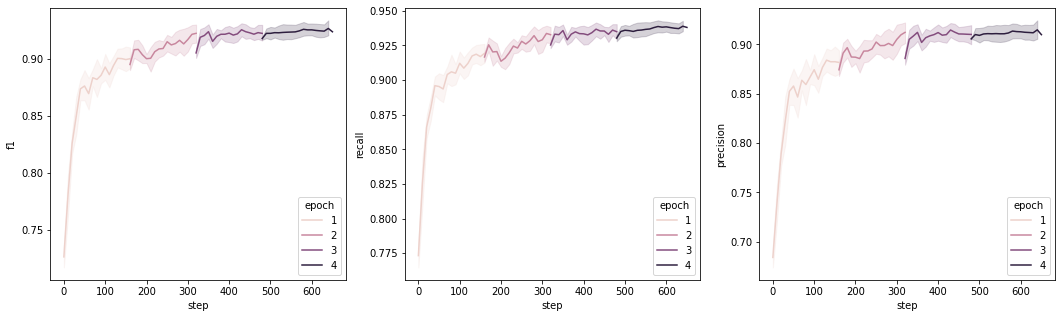

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))
seaborn.lineplot(data=eval_history, x='step', y='f1', hue='epoch', ax=ax[0])
seaborn.lineplot(data=eval_history, x='step', y='recall', hue='epoch', ax=ax[1])
seaborn.lineplot(data=eval_history, x='step', y='precision', hue='epoch', ax=ax[2])

In [13]:
test_scores.round(2)

,fold,f1,precision,recall
0,0,0.93,0.91,0.95
1,1,0.92,0.90,0.94
2,2,0.93,0.92,0.94
3,3,0.93,0.91,0.94
4,4,0.92,0.91,0.94
5,5,0.93,0.92,0.95
6,6,0.93,0.92,0.94
7,7,0.93,0.92,0.94
8,8,0.93,0.92,0.94
9,9,0.92,0.91,0.94
